In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/HeartAttackAnalysis/'

## 컬럼 정보


- **Age**: 환자의 나이
- **Sex**: 환자의 성별
- **exang**: 운동으로 유발되는 협심증 (1 = 예, 0 = 아니요)
- **ca**: 주요 혈관 수 (0~3)
- **cp**: 흉통 유형
  - 값 1: 전형적인 협심증
  - 값 2: 비전형적인 협심증
  - 값 3: 비협심증성 통증
  - 값 4: 무증상
- **trtbps**: 안정 시 혈압 (mm Hg 단위)
- **chol**: BMI 센서를 통해 측정된 콜레스테롤 수치 (mg/dl 단위)
- **fbs**: 공복 혈당 > 120 mg/dl (1 = 참, 0 = 거짓)
- **rest_ecg**: 안정 시 심전도 결과
  - 값 0: 정상
  - 값 1: ST-T 파형 이상 (T 파형 역전 또는 ST 상승/하강이 0.05 mV 이상)
  - 값 2: Estes 기준에 따른 좌심실 비대 가능성 또는 확실성
- **thalach**: 최대 심박수
- **target**: 0 = 심장마비 가능성 낮음, 1 = 심장마비 가능성 높음


우리 목표는 위 데이터를 이용하여 심장마비 가능성에 대하여 탐색하는 것.

In [4]:
# 기본 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 모델링용 라이브러리 불러오기
# scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# epdlxj rnqns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 기타 라이브러리 불러기기
import joblib
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format='retina'

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## 데이터 로딩

In [5]:
path = '/content/drive/MyDrive/HeartAttackAnalysis/'

In [6]:
data = pd.read_csv(path + 'heart.csv')

In [7]:
data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### 기본 정보

In [8]:
data.shape

(303, 14)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [10]:
data.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [11]:
data.isnull().sum()

,0
age,0
sex,0
cp,0
trtbps,0
chol,0
fbs,0
restecg,0
thalachh,0
exng,0
oldpeak,0


In [ ]:
# null 없음!

# EDA

In [12]:
# 숫자형 단변량
def univariate_analysis(dataframe:pd.DataFrame, column:str):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    sns.histplot(data=dataframe, x=column)
    plt.title('Histogram (kde)')

    plt.subplot(1,2,2)
    sns.boxplot(x=dataframe[column])
    plt.title('Boc plot')

    plt.title('Histogram (kde)')

    print('기술통계량')
    print(dataframe[column].describe())

기술통계량
count    303.000000
mean      54.366337
std        9.082101
min       29.000000
25%       47.500000
50%       55.000000
75%       61.000000
max       77.000000
Name: age, dtype: float64
기술통계량
count    303.000000
mean       0.683168
std        0.466011
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: sex, dtype: float64
기술통계량
count    303.000000
mean       0.966997
std        1.032052
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: cp, dtype: float64
기술통계량
count    303.000000
mean     131.623762
std       17.538143
min       94.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: trtbps, dtype: float64
기술통계량
count    303.000000
mean     246.264026
std       51.830751
min      126.000000
25%      211.000000
50%      240.000000
75%      274.500000
max      564.000000
Name: chol, dtype: float64
기술통계량
count    303.000000
mean       

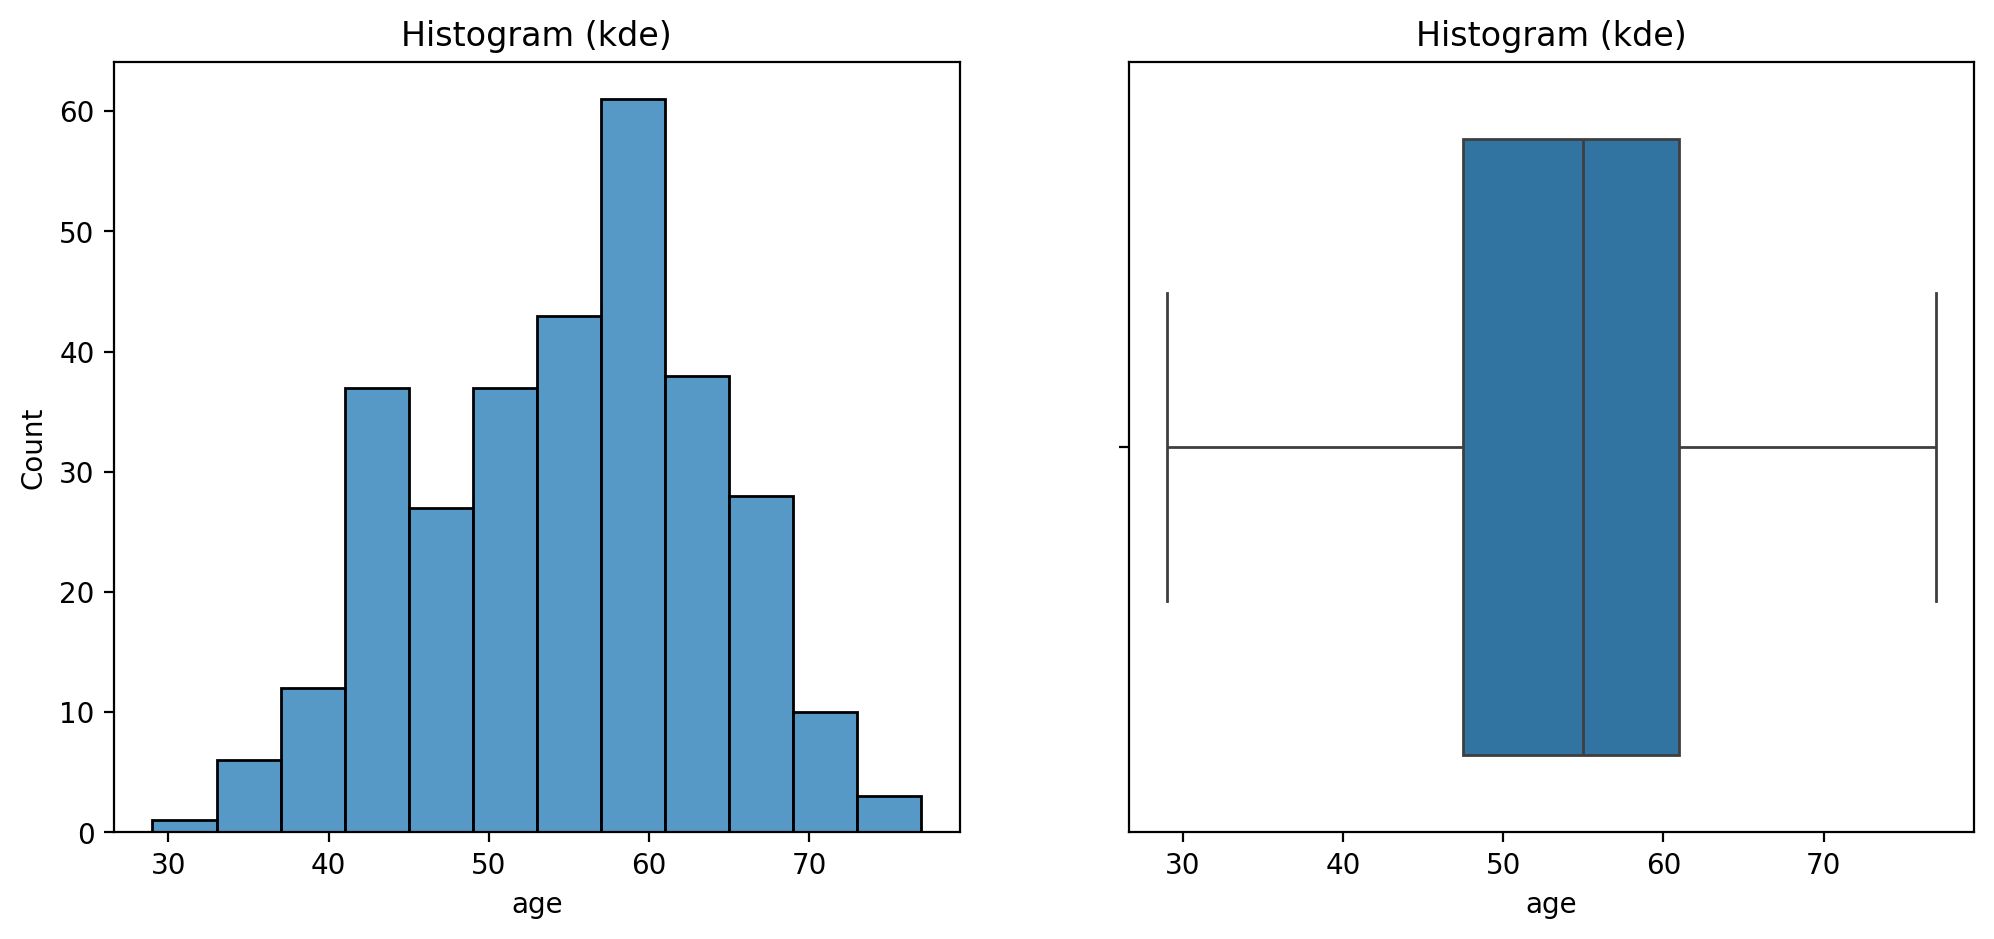

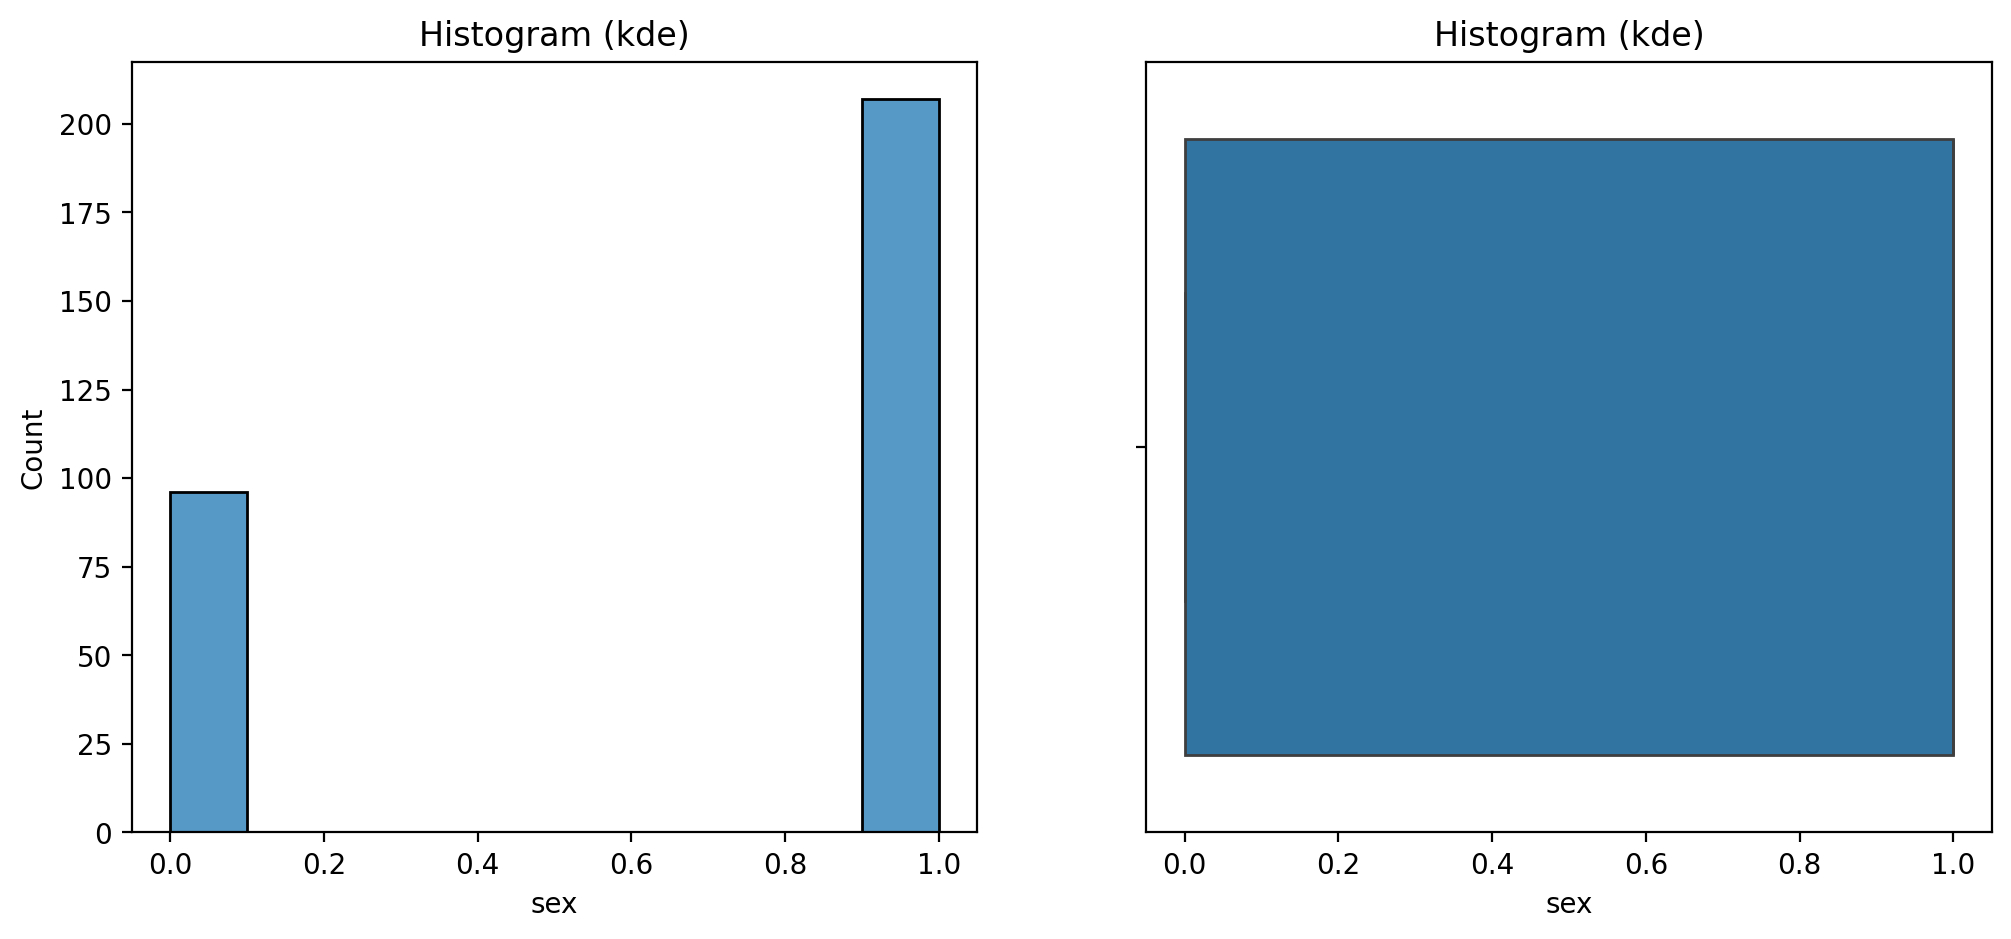

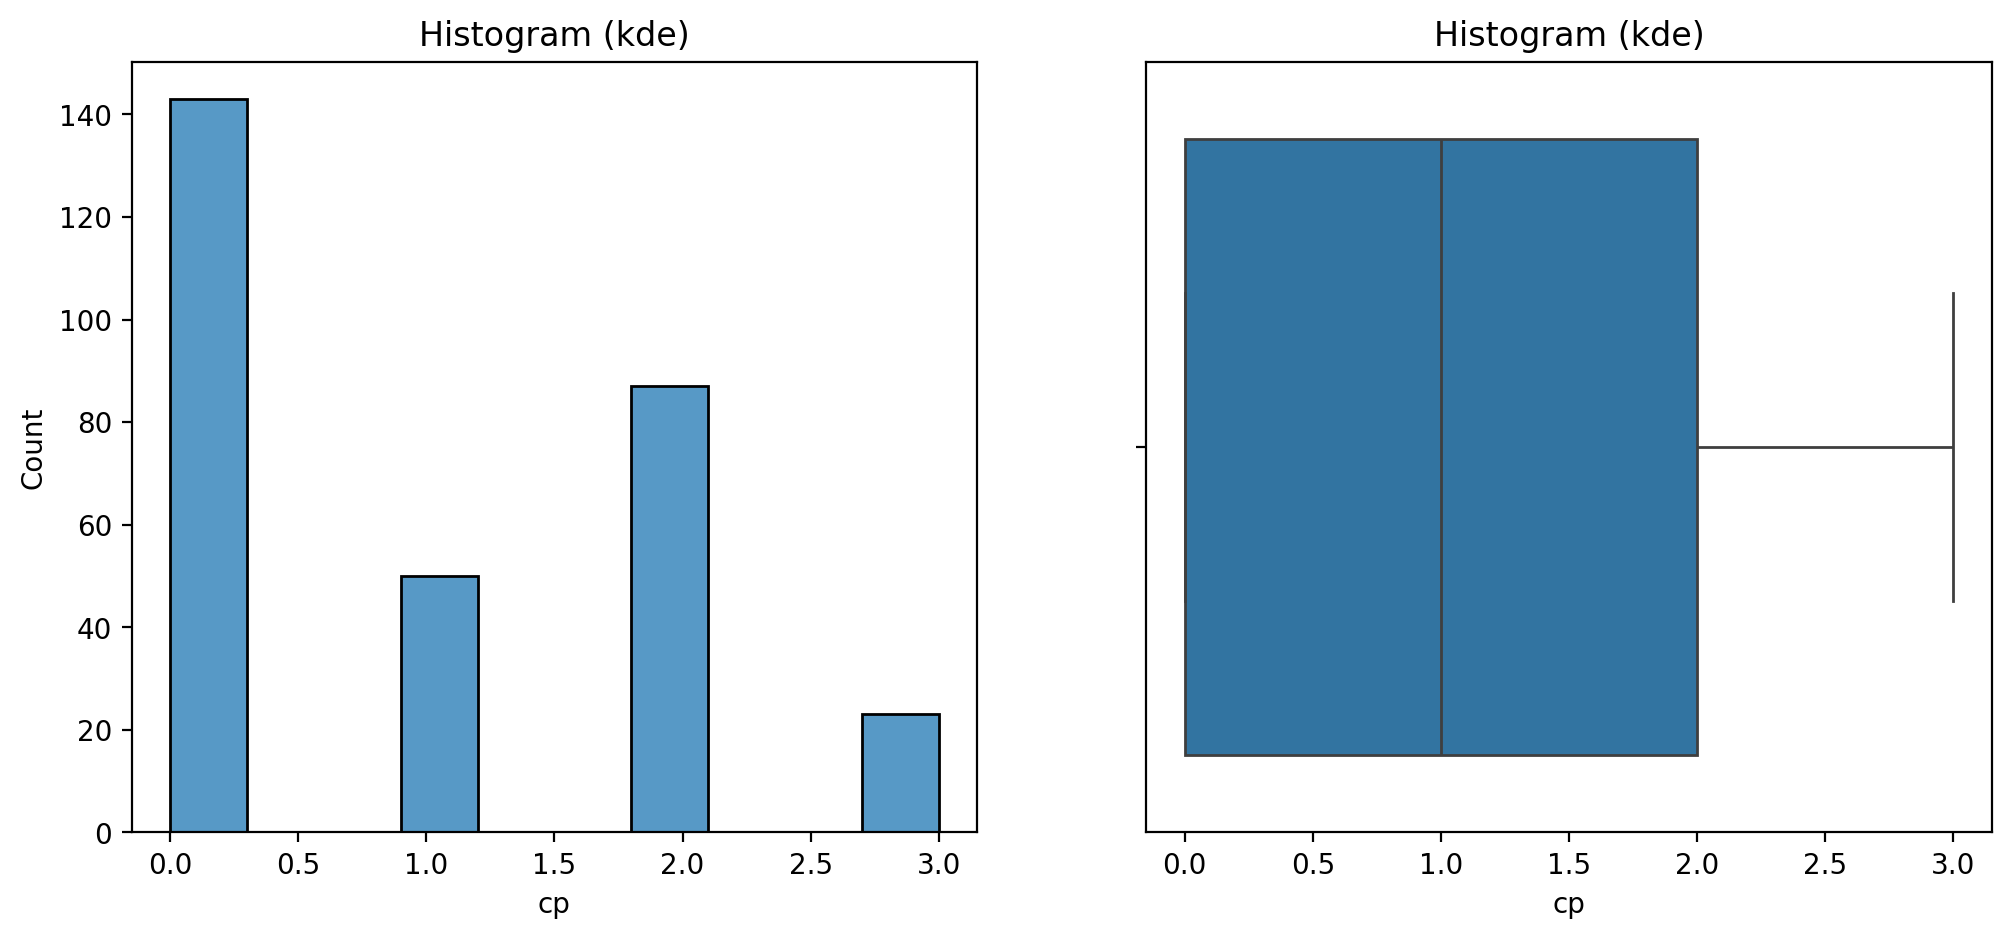

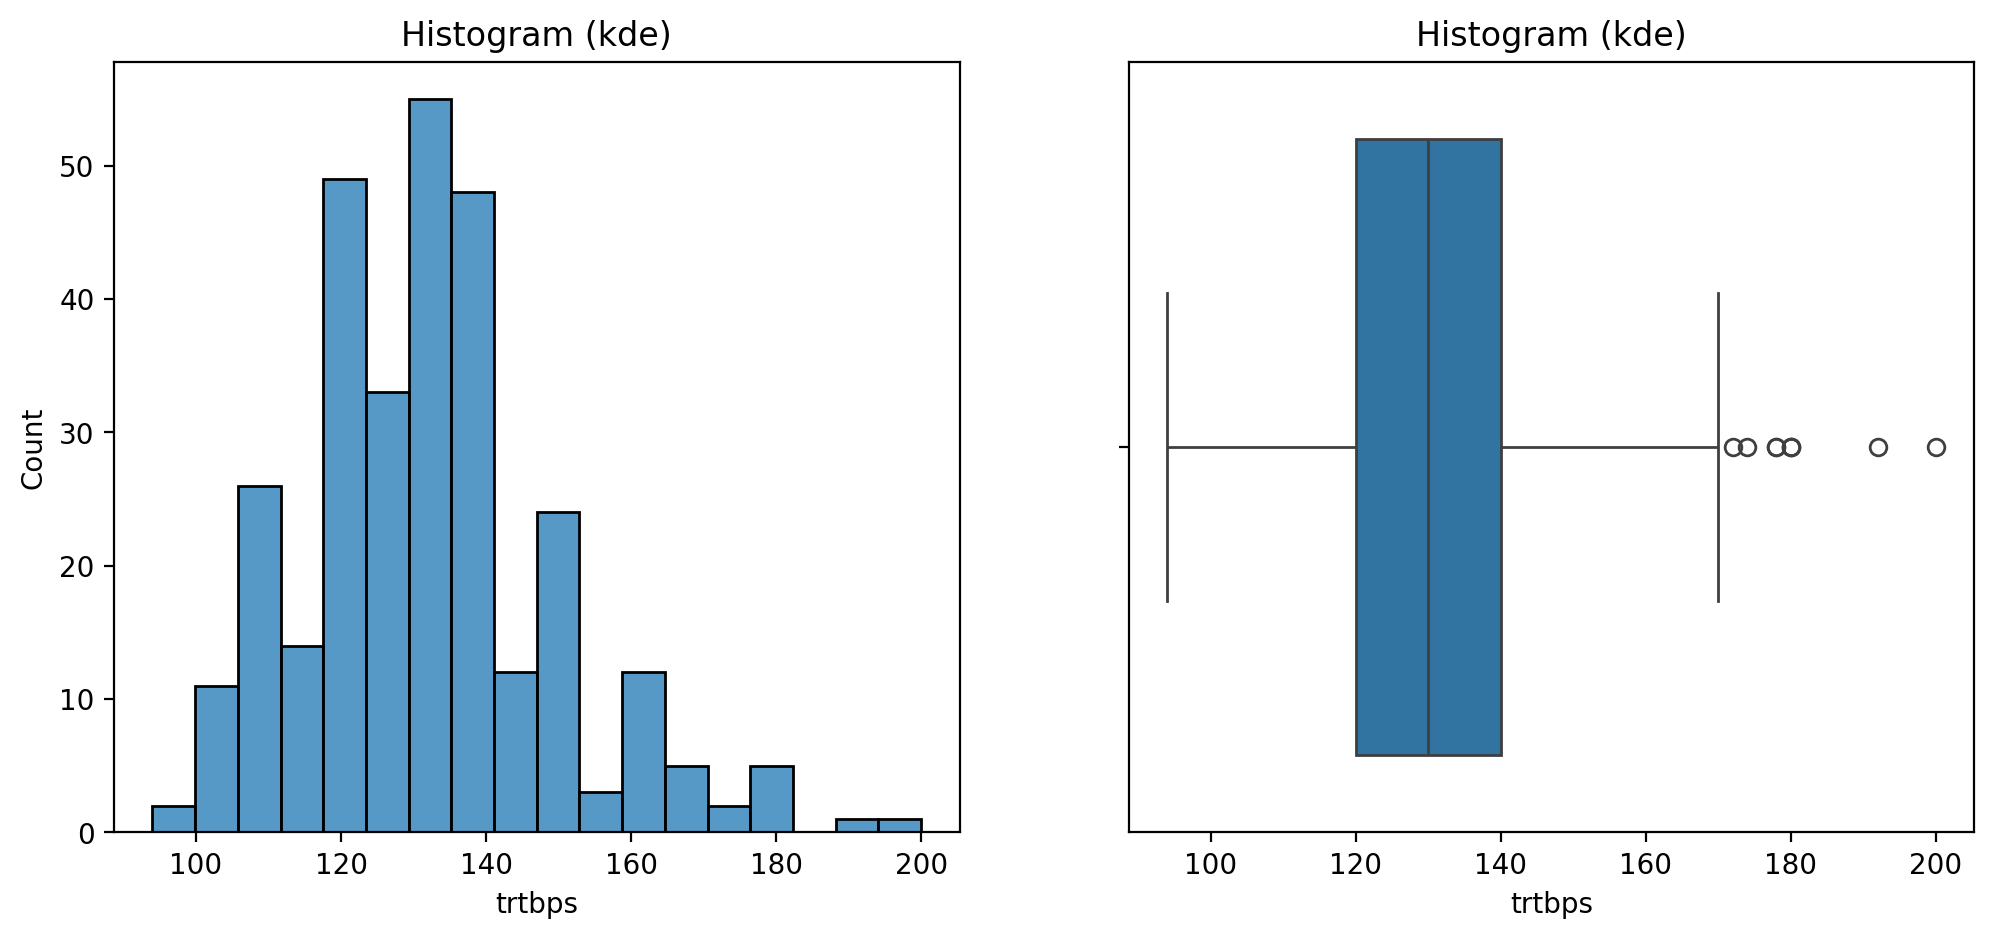

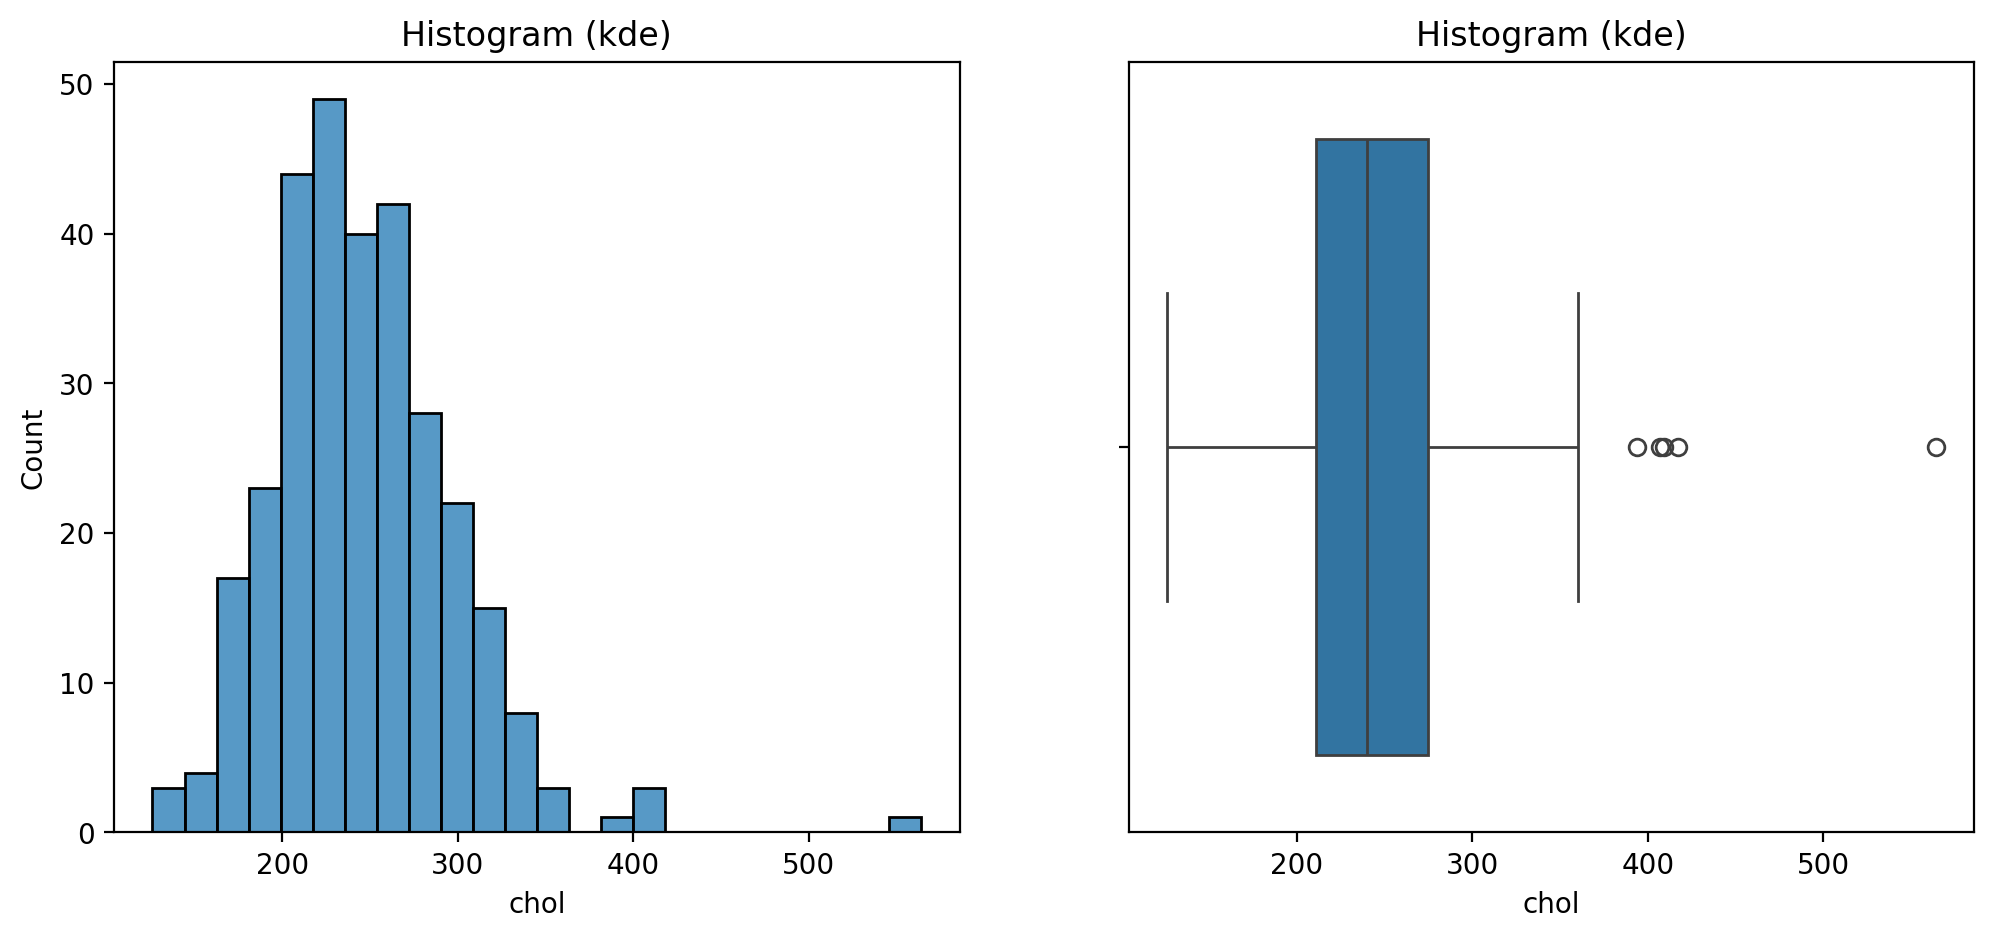

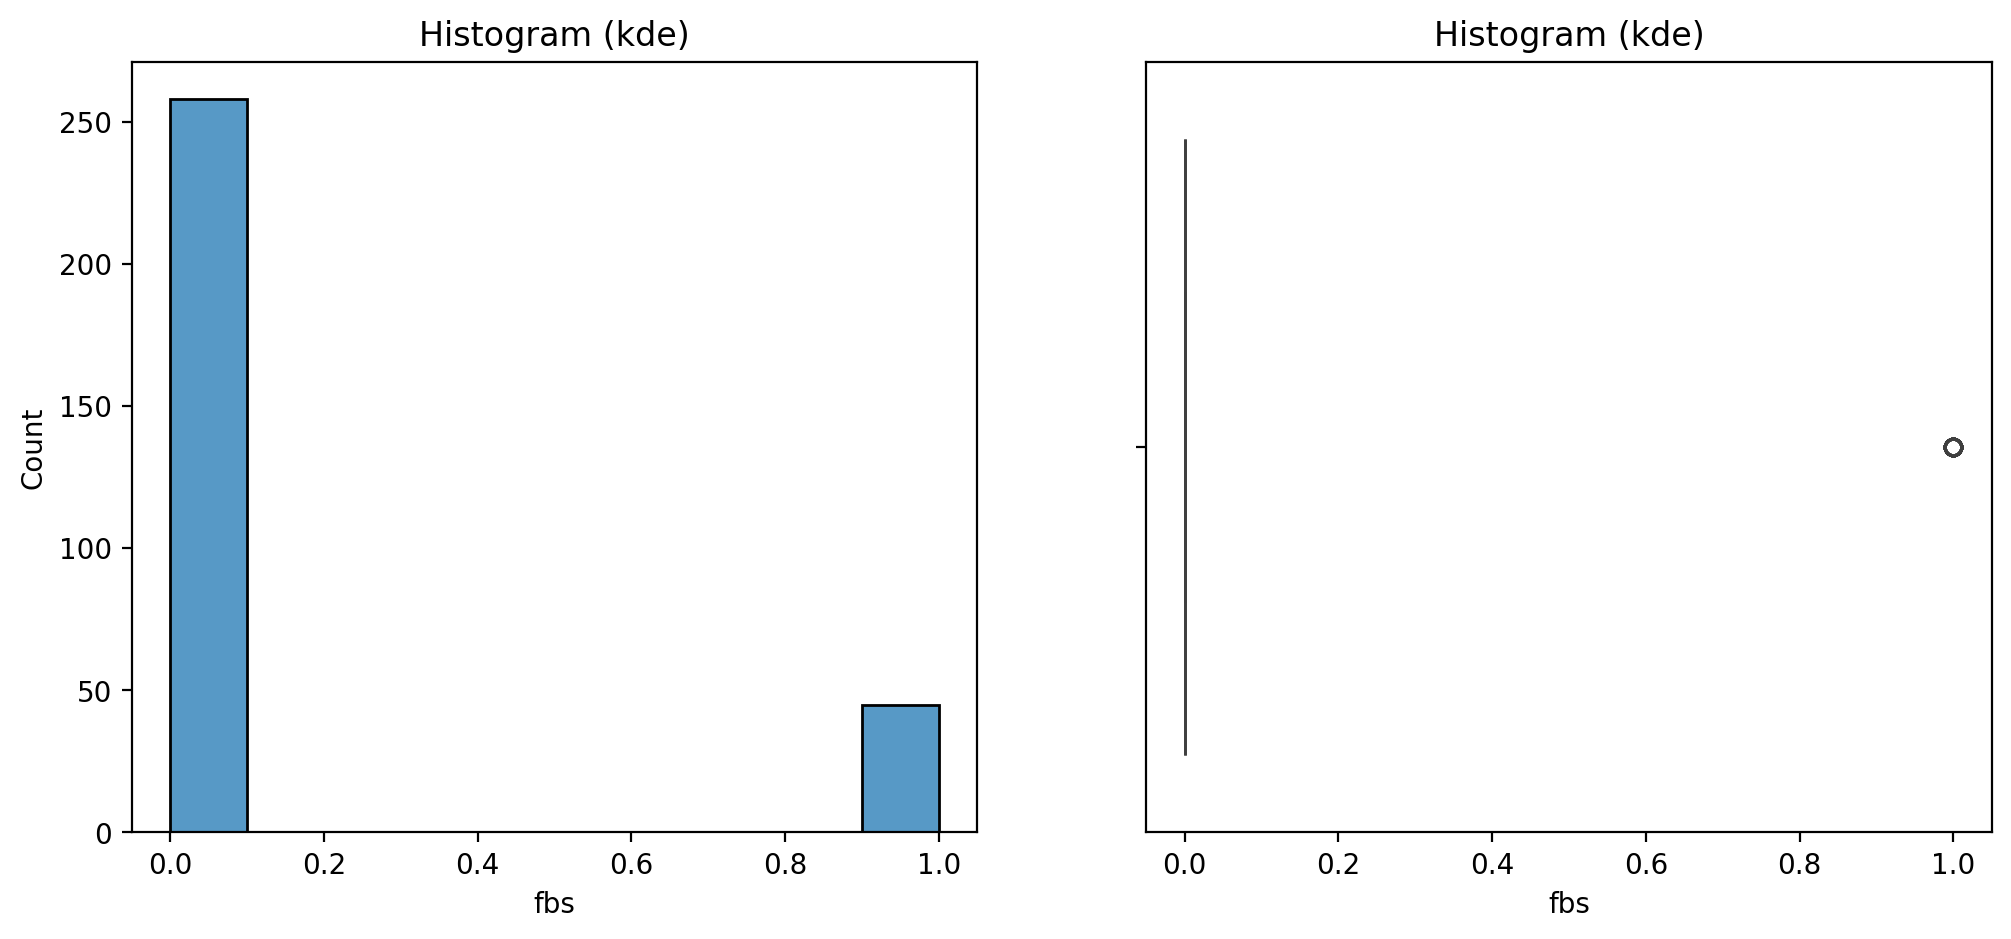

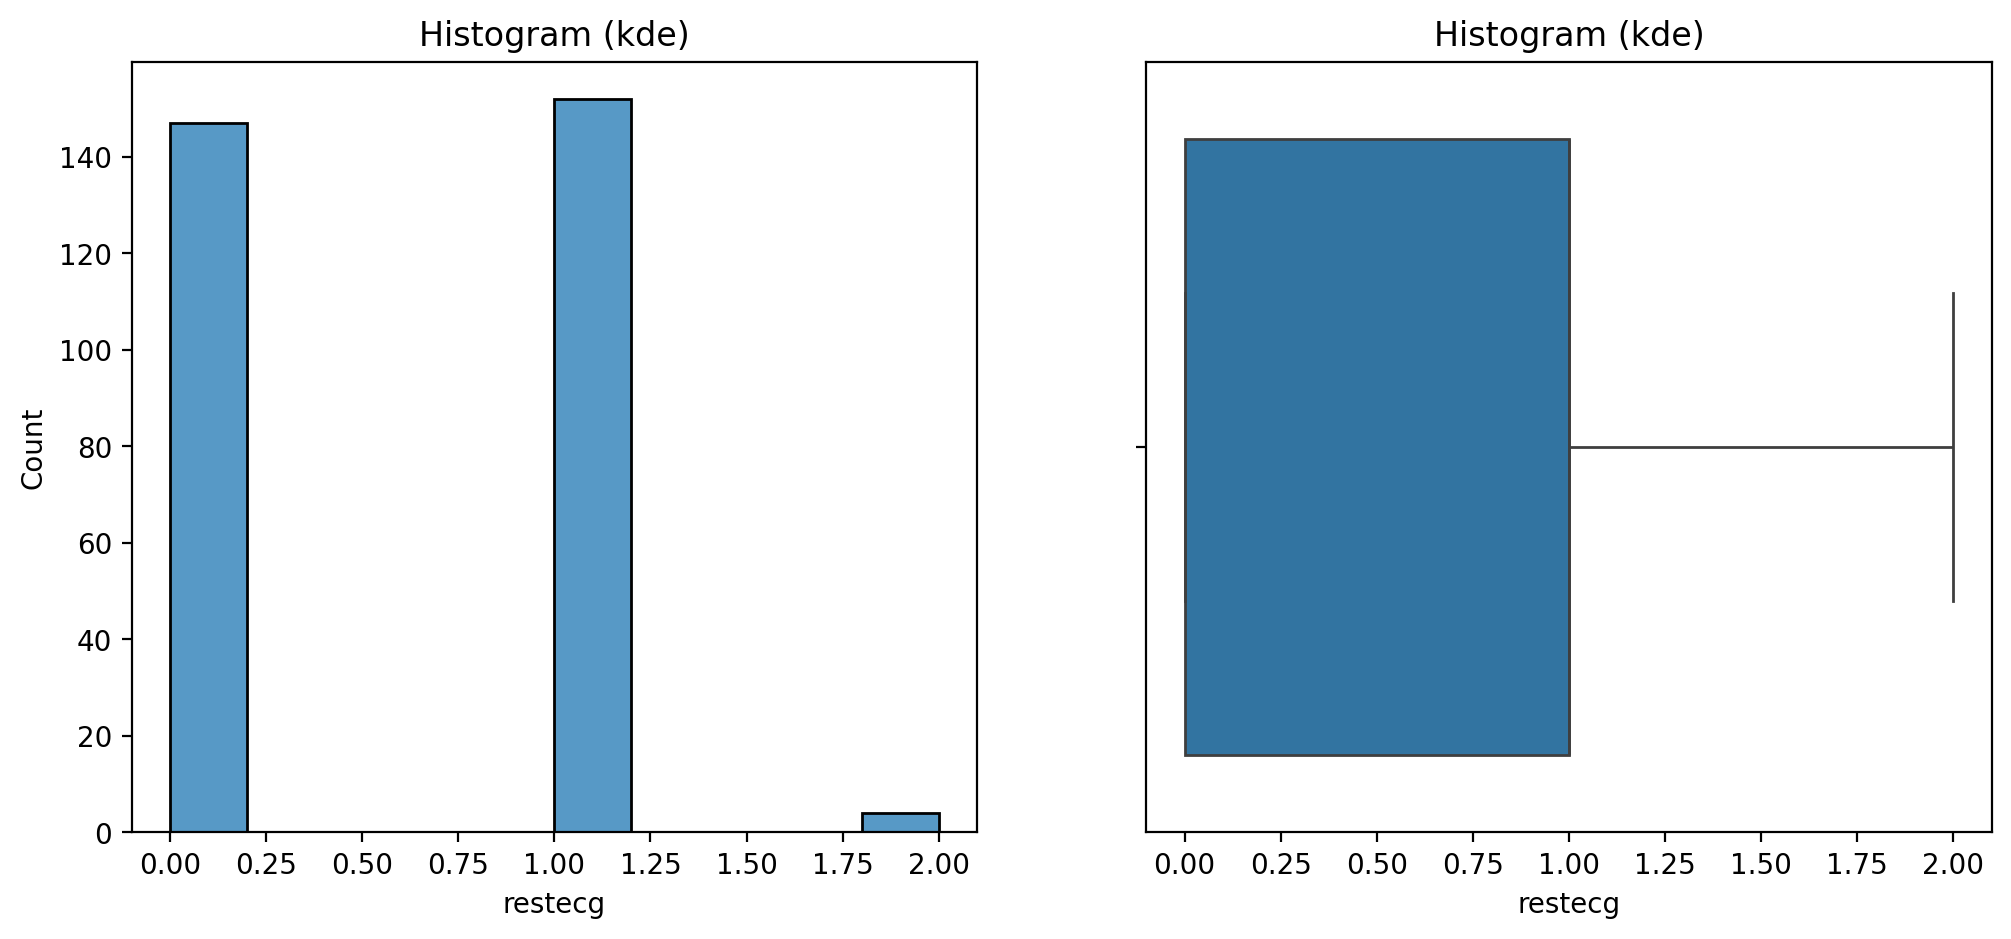

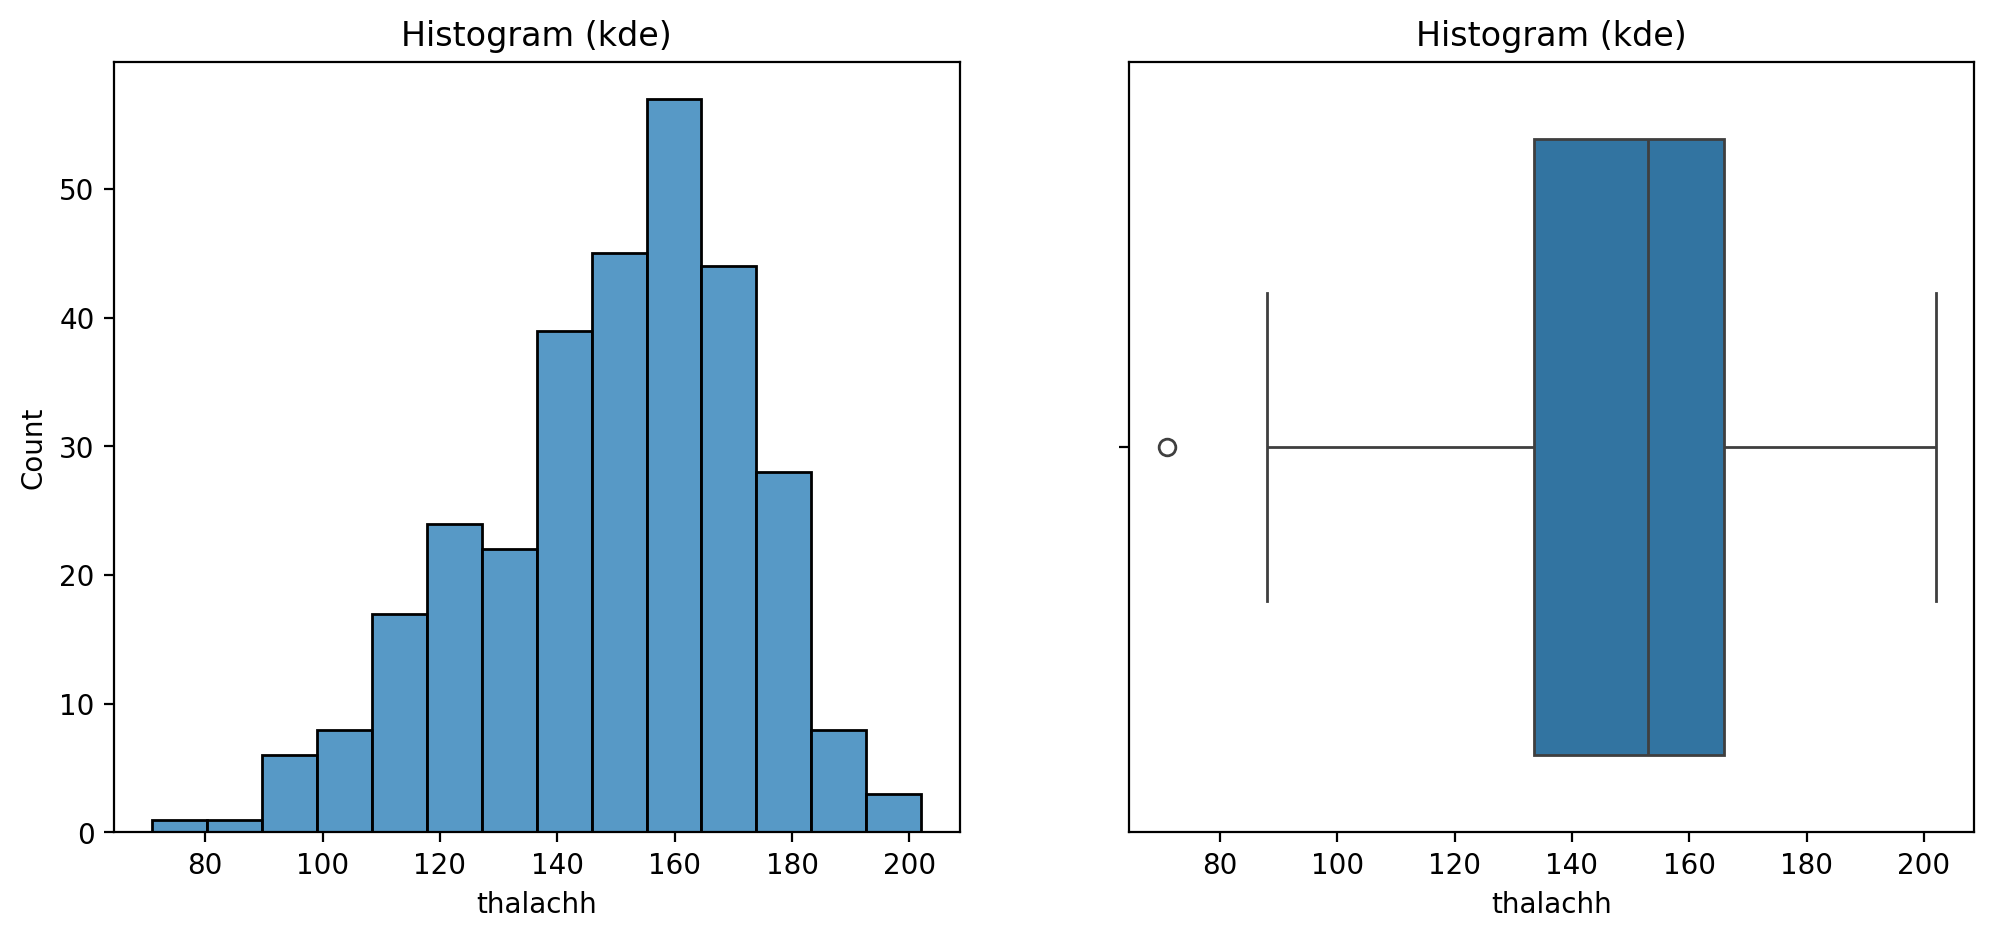

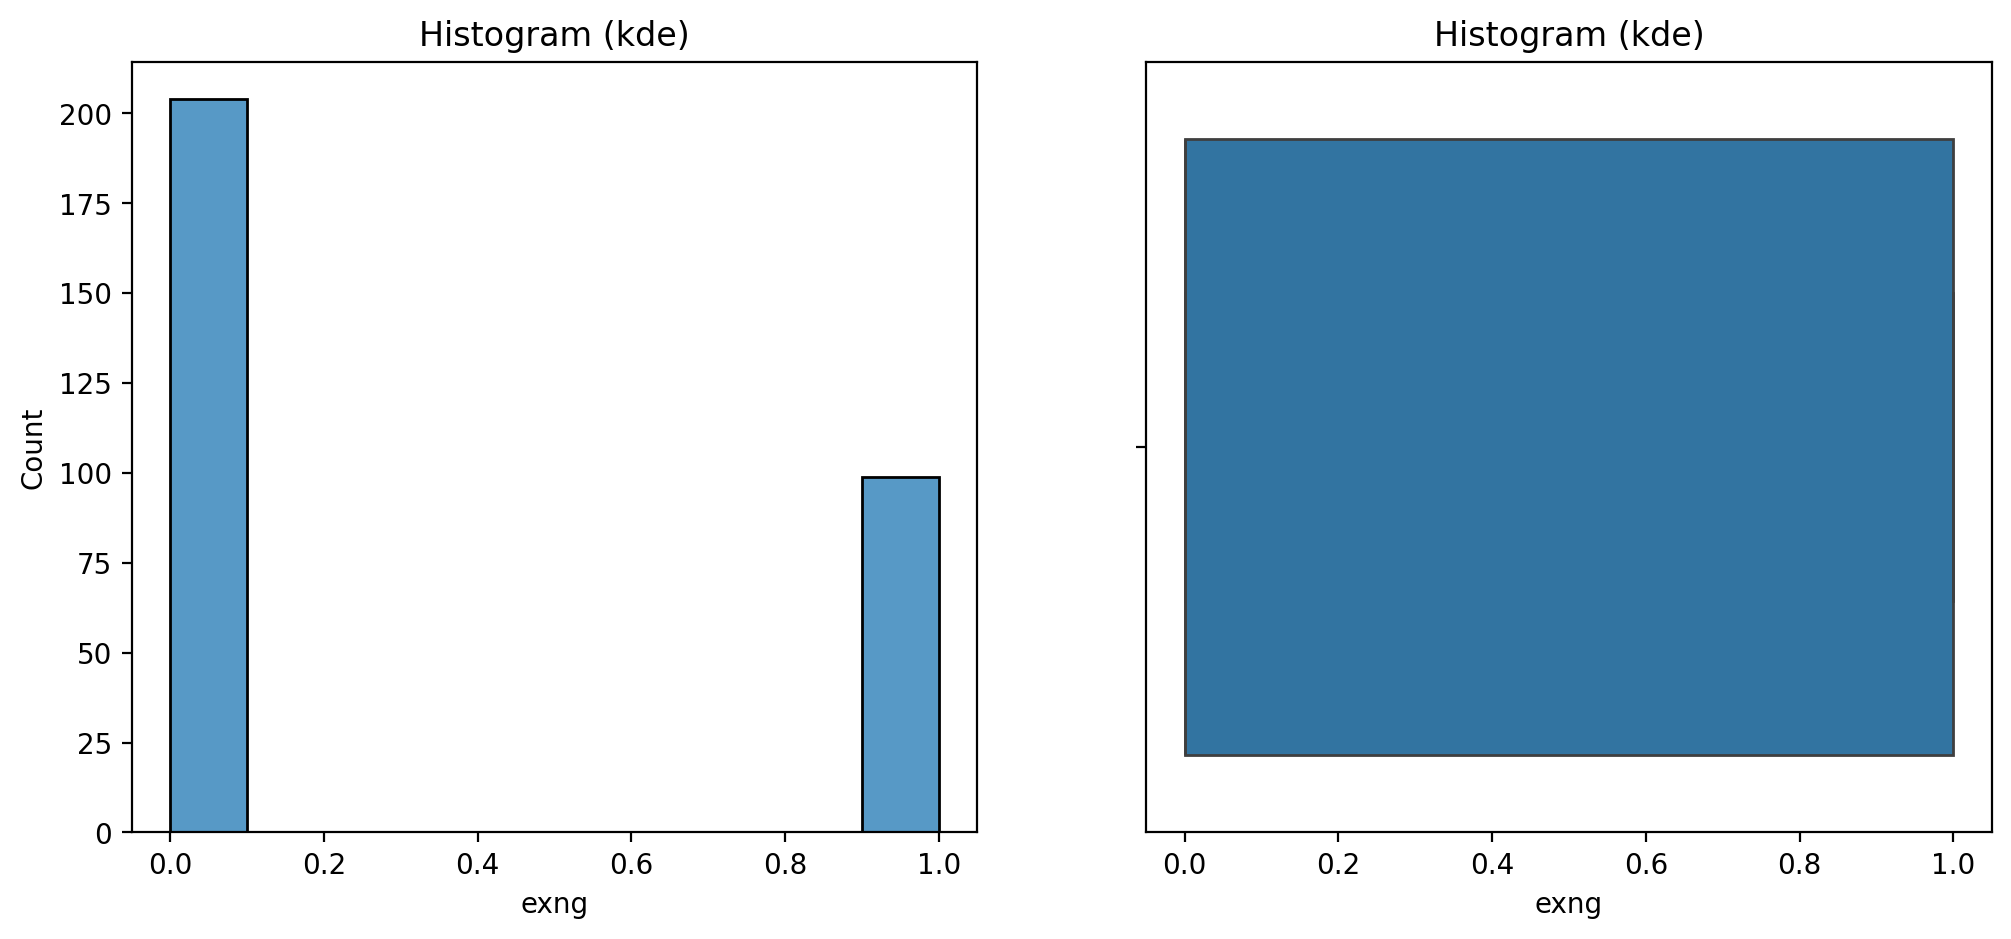

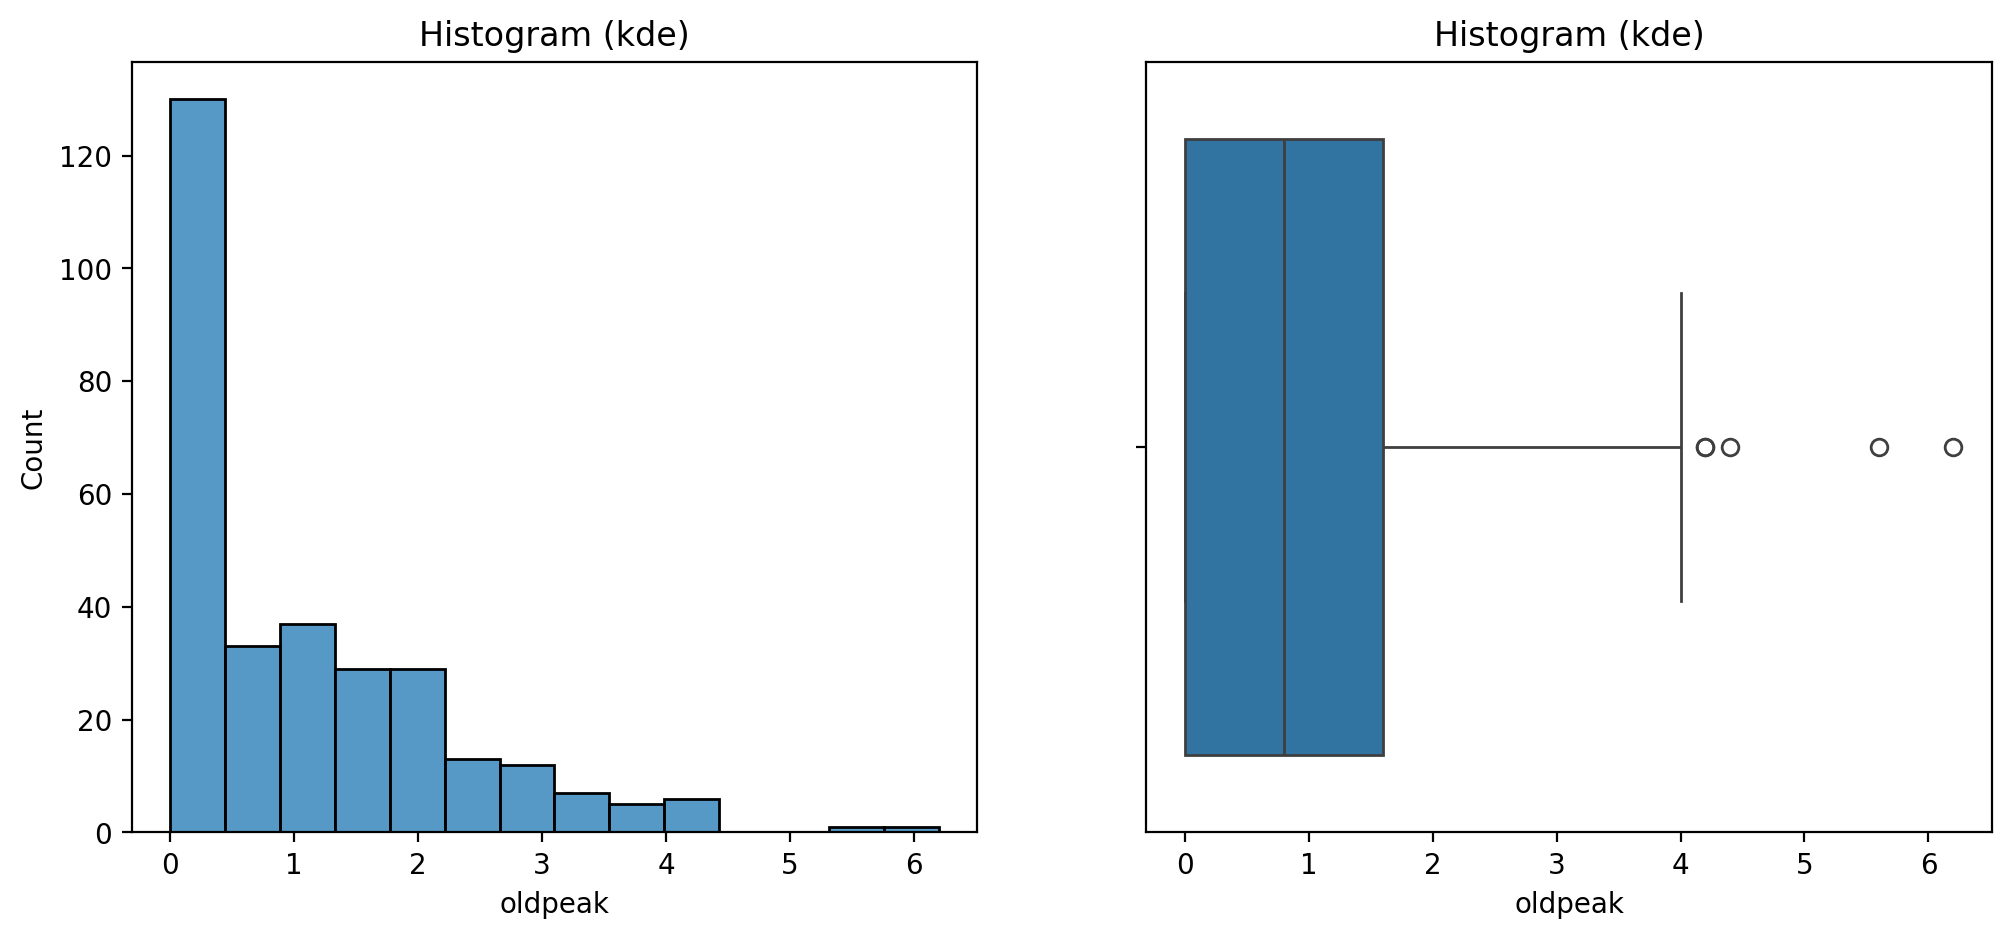

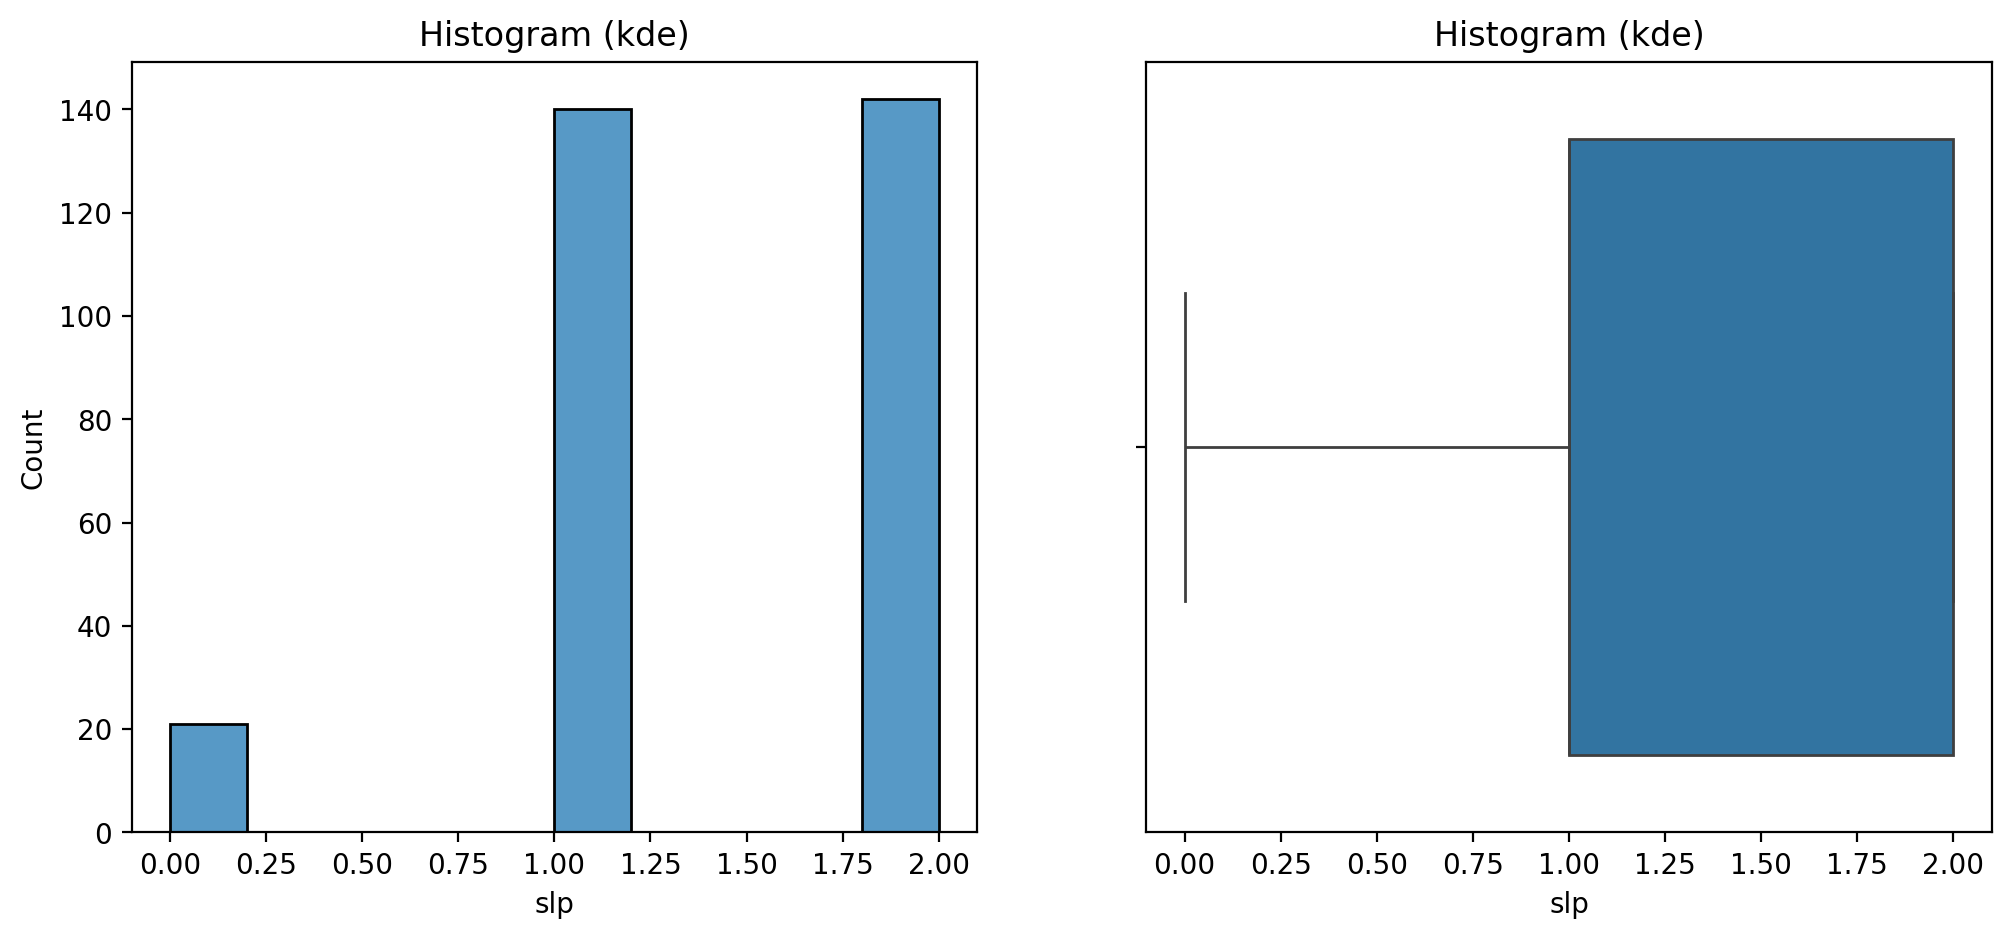

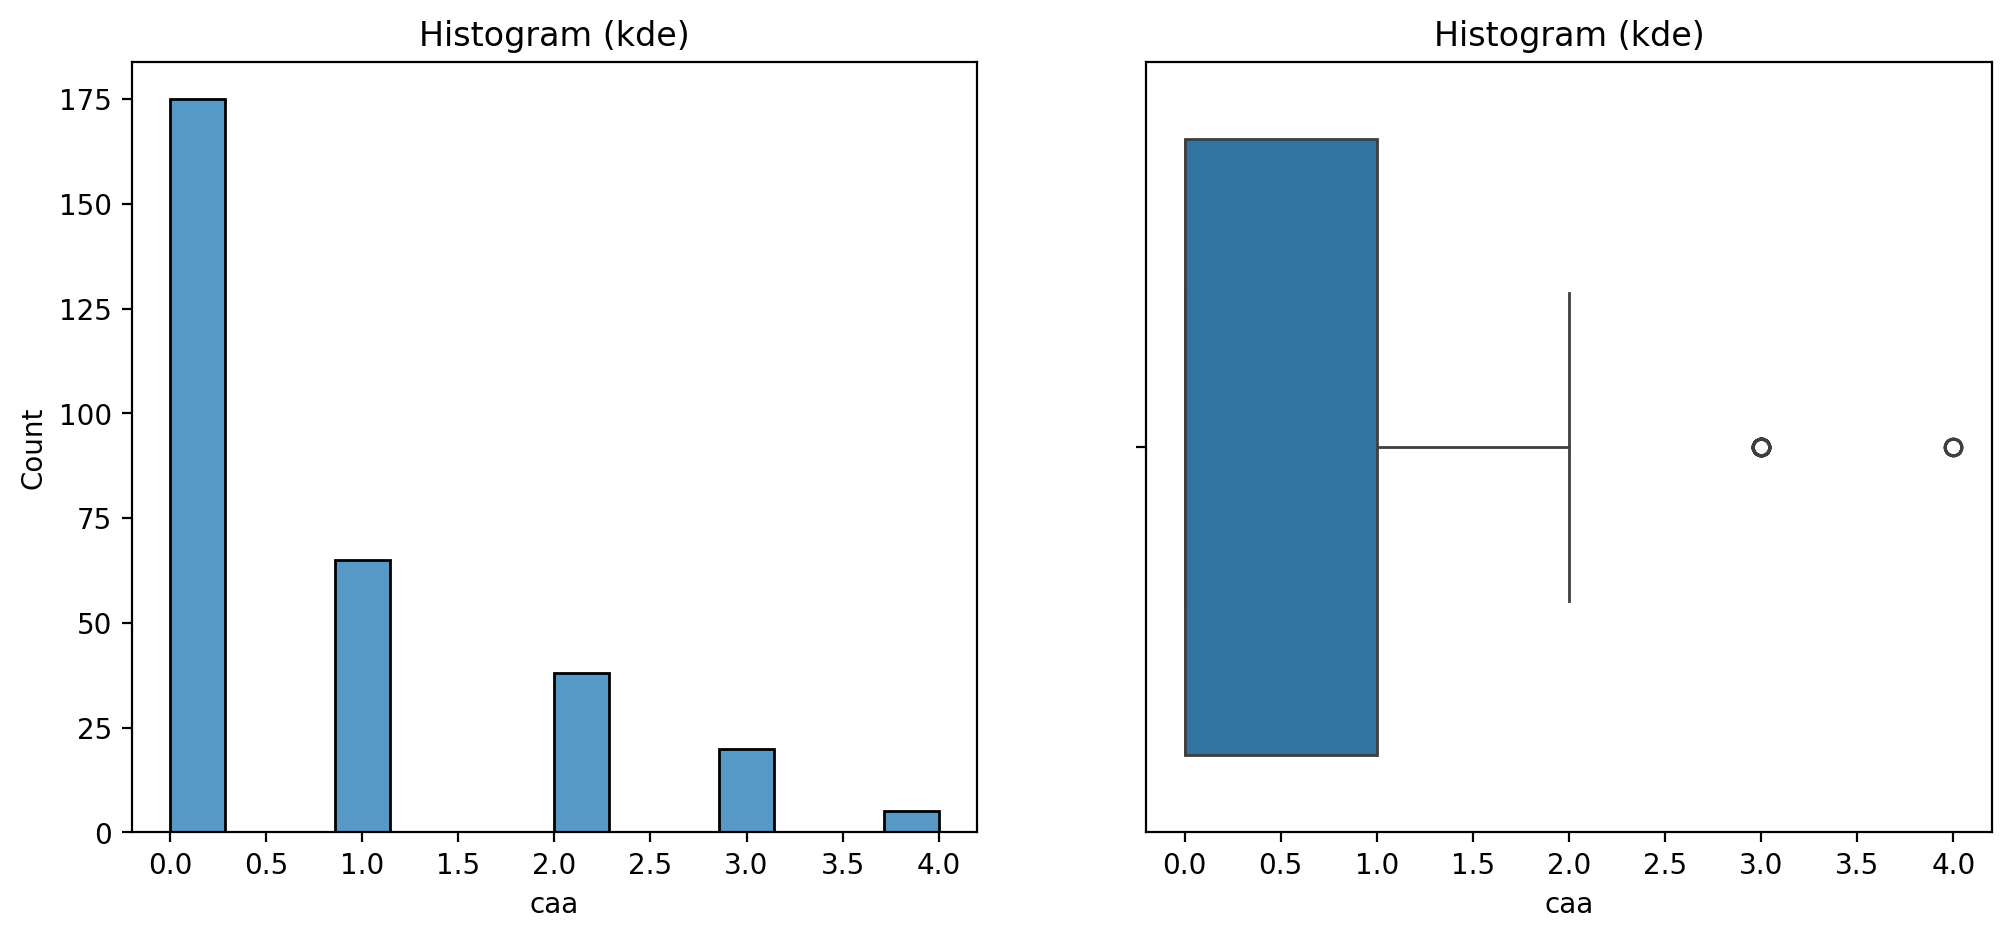

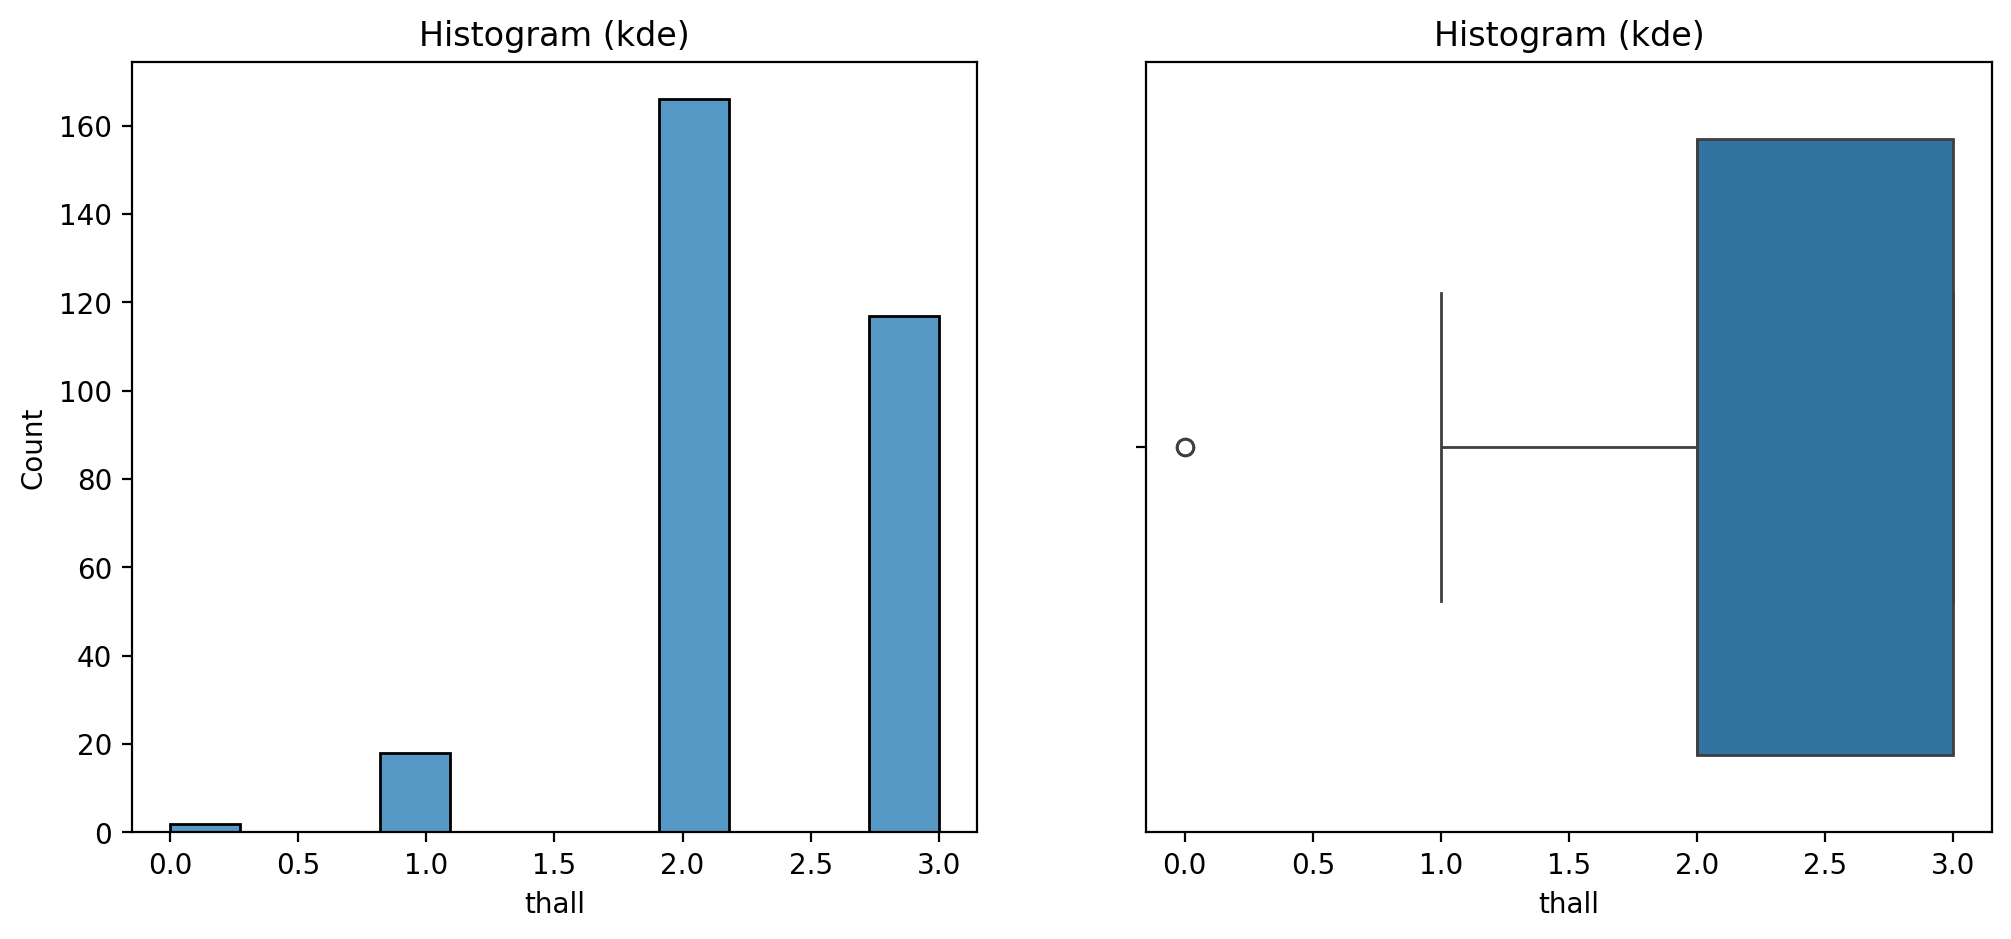

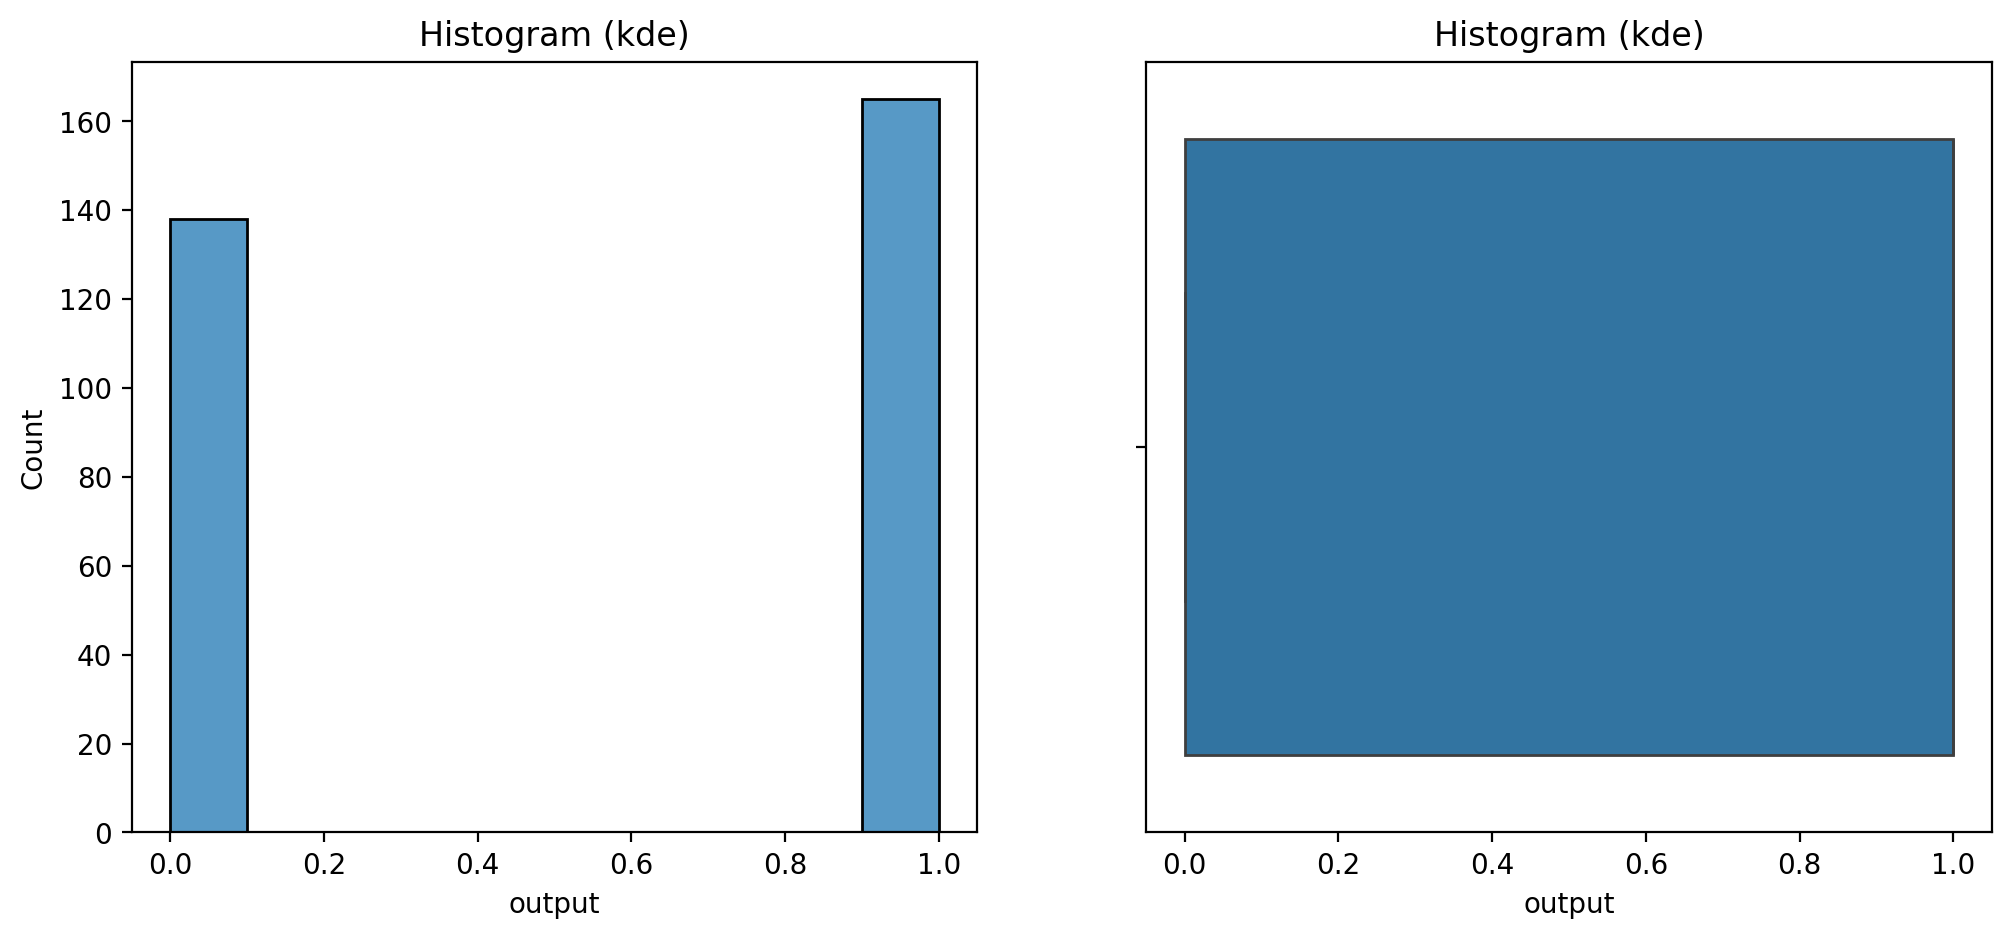

In [13]:
for col in data.columns:
    univariate_analysis(data, col)

In [14]:
data['cp'].value_counts()

,count
cp,
0,143
2,87
1,50
3,23


### 단변량 분석 의견


1. **Age (나이)**:
   - 평균 나이: 54세
   - 최소 나이: 29세, 최대 나이: 77세
   - 환자들은 주로 중년층 이상, 심장 환자들 데이터만 모아놓은 거라서 아무래도 데이터가 중년층 이상에 집중됨.

2. **Sex (성별)**:
   - 평균: 0.68 =>약 68%의 환자가 1
   - 성별이 1인 쪽이 심장 질환을 더 많이 겪는 듯.

3. **cp (Chest Pain type, 흉통 유형)**:
   - 평균: 0.97 => 전형적인 경우가 가장 많고 그 다음은 비협심증성 통증
    - 값 1(0): 전형적인 협심증
    - 값 2(1): 비전형적인 협심증
    - 값 3(2): 비협심증성 통증
    - 값 4(3): 무증상

4. **trtbps (Resting Blood Pressure, 안정 시 혈압)**:
   - 평균 혈압: 131.6 mm Hg
   - 최소 혈압: 94 mm Hg, 최대 혈압: 200 mm Hg
   - 정상치는 수축기 120mmHg 미만과 이완기 80mmHg 미만이며, 수축기 혈압 120~139mmHg 또는 이완기 혈압 80~89mmHg까지는 고혈압 전단계, 넘어가면 고혈압임.
   - 고혈압 전단계가 가장 많음.

5. **chol (콜레스테롤 수치)**:
   - 평균 콜레스테롤 수치: 246 mg/dl
   - 최소 콜레스테롤 수치: 126 mg/dl, 최대 콜레스테롤 수치: 564 mg/dl
   - 140~ 200이 정상임. 평균적인 콜레스테롤이 너무 높음

6. **fbs (Fasting Blood Sugar, 공복 혈당)**:
   - 평균: 0.15 => 약 15%의 환자가 공복 혈당이 120 mg/dl를 넘음.

7. **thalachh (Max Heart Rate Achieved, 최대 심박수)**:
   - 평균 최대 심박수: 149.6
   - 최소: 71, 최대: 202
   - 심박수 정상은 `220 - 나이`. 의외로 다들 정상임.

8. **exng (Exercise Induced Angina, 운동 유발 협심증)**:
   - 평균: 0.33 => 약 32.7%의 환자가 운동으로 유발되는 협심증을 겪음.

12. **output (Target, 심장마비 가능성)**:
   - 평균: 0.54 => 심장마비 가능성이 높은 환자가 약 54%.

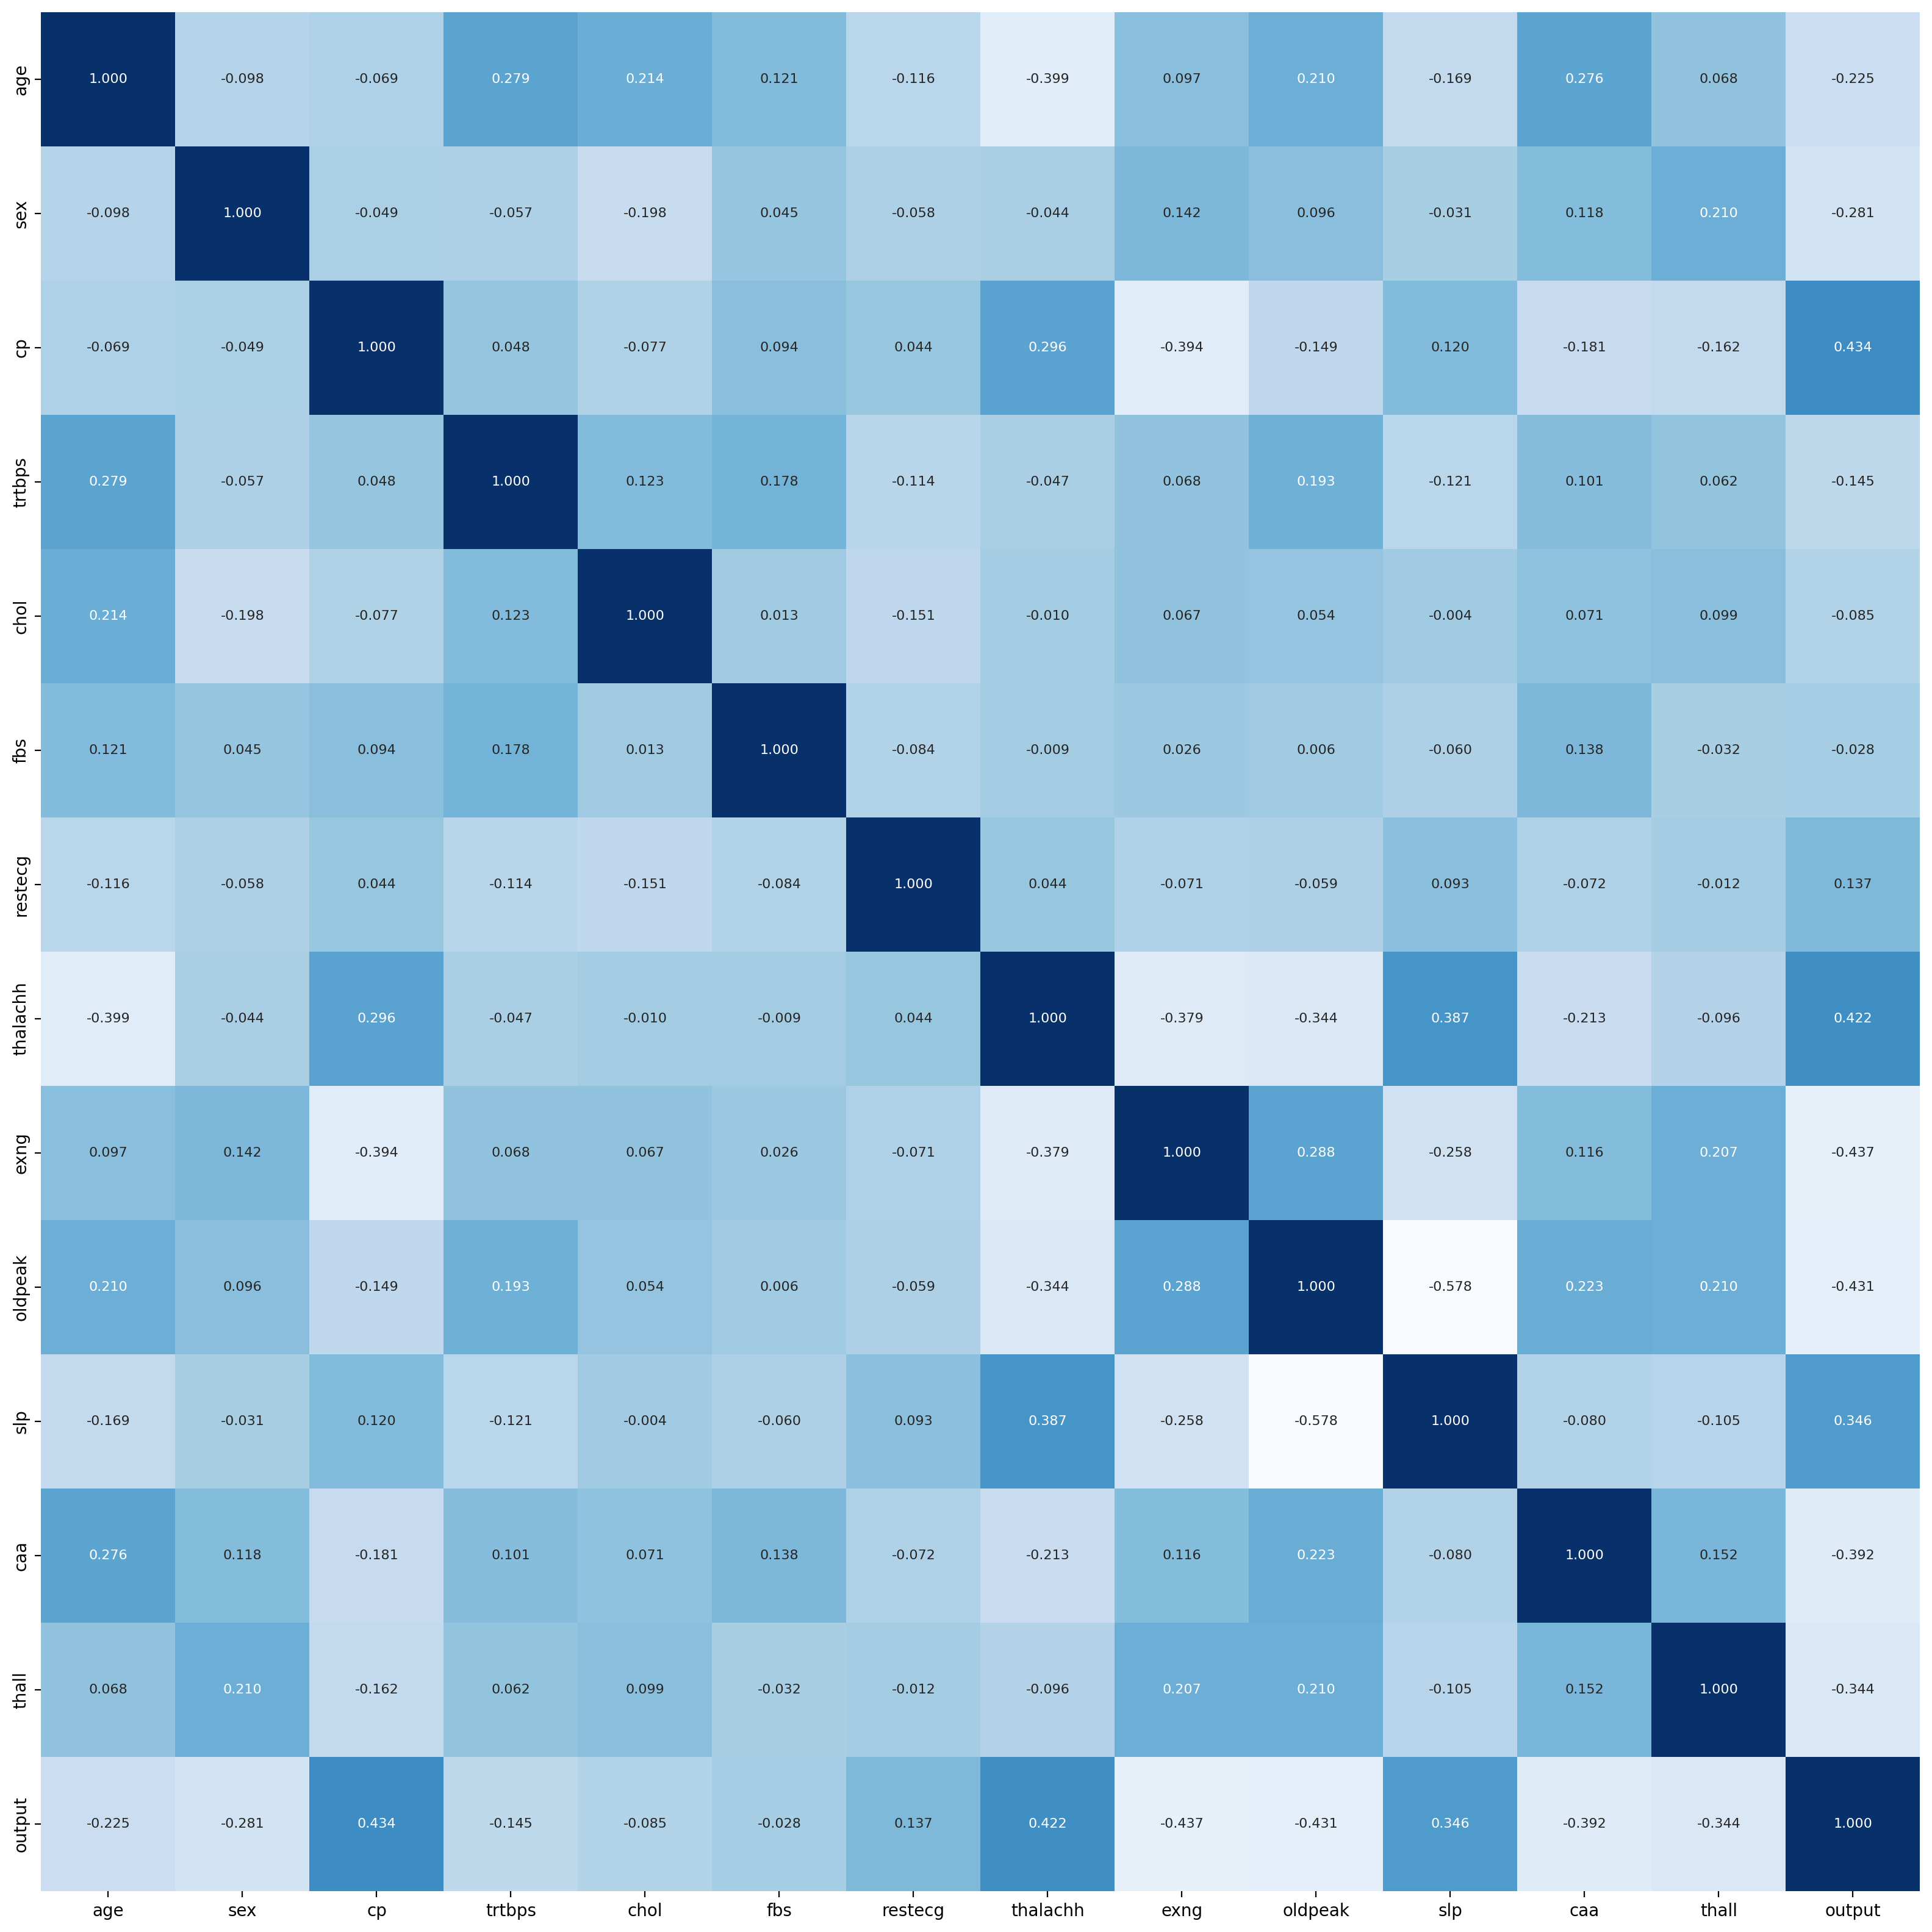

In [15]:
# 관계도
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(numeric_only=True),
            annot=True,
            cmap='Blues',
            cbar=False,
            square=True,
            fmt='.3f',
            annot_kws={'size': 8})

plt.show()

cp, 안전혈압, slp에 큰 영향을 받음.
exng,oldpeak,caa,thall이 높은 음의 상관관계

- old와 slp는 ST관련 변수
    - ** ST 세그먼트 ** : 심장의 전기적 활동을 기록한 심전도에서 QRS 파형 후와 T 파형 전 사이의 구간을 말함.
        - ST 하강 (oldpeak) 은 심장이 산소를 제대로 못받는거, slp의 급격한 변화는 무조건 안좋음

# EDA기반 가설
- 하나같이 0.5를 못넘으므로 linear Regration은 제외.
- 사실상의 범주가 많아서 Random Forest 우세할 것으로 예상.
- 앵간 0.1은 넘으므로 따로 변수를 제외할 필요는 없어 보임. p-val 낮은거 있으면 그거나 한번 제외.
- 0.1보다 낮은것도 제해보기로.

In [22]:
import scipy.stats as spst

# 함수 만들기
def top_correlations(dataframe:pd.DataFrame, target, consider_pVal = False, only_strong = False):
    result = []
    # print(dataframe.columns)
    for i in dataframe.columns:
        if i==target or not pd.api.types.is_numeric_dtype(dataframe[i]):
            continue

        if dataframe[i].nunique() <= 1 or dataframe[target].nunique() <= 1:
            continue

        try:
            corr, p_val = spst.pearsonr(dataframe[target], dataframe[i])
        except Exception as e:
            print(f"Pearson 계산 중 오류 발생: {e}")
            continue


        p_condition = True
        strong_condition = True

        if consider_pVal:
            p_condition = p_val < 0.05

        if only_strong:
            strong_condition = abs(corr)>0.1

        if p_condition and strong_condition:
            # print('im in!')
            result.append((corr, p_val, i))
    return sorted(result, reverse=True)

def scatterplot(dataframe:pd.DataFrame, x ,target):
    plt.figure(figsize=(12,4))
    # plt.title(target)
    plt.subplot(1,2,1)
    sns.scatterplot(data=dataframe, x=x,y=target)
    plt.xticks(rotation=45)
    # sns.lineplot(data=dataframe, x=x,y=target)

    plt.subplot(1,2,2)
    sns.boxplot(x=target, data=data)
    plt.xticks(rotation=45)
    plt.show()

    sns.lmplot(data=dataframe, x=x,y=target)
    plt.show()


In [23]:
target = 'output'

In [27]:
for i in top_correlations(data, target, True, True):
    try:
        print(f'{i[2]} , corr : {i[0]}, p-val : {i[1]}')
    except Exception as e:
        print(f'{i}는 상관분석 불가 \n{i}')

cp , corr : 0.4337982615068943, p-val : 2.4697121089224823e-15
thalachh , corr : 0.4217409338106744, p-val : 1.6973376386561556e-14
slp , corr : 0.34587707824172503, p-val : 6.101610619564451e-10
restecg , corr : 0.13722950287377308, p-val : 0.016839897060126837
trtbps , corr : -0.14493112849775155, p-val : 0.01154605920023343
age , corr : -0.22543871587483727, p-val : 7.52480130344234e-05
sex , corr : -0.28093657550176704, p-val : 6.678692115314122e-07
thall , corr : -0.34402926803831024, p-val : 7.624879909571822e-10
caa , corr : -0.39172399235125277, p-val : 1.4915387381120468e-12
oldpeak , corr : -0.4306960016873688, p-val : 4.085346391354466e-15
exng , corr : -0.43675708335330304, p-val : 1.5208138383314356e-15


# 학습 전 전처리

In [ ]:
# 따로 drop은 안할거임. 0.5 다 안넘으니 다중 공선성도 없지 않을까

In [28]:
x = data.drop(columns=[target])
y = data[target]

In [29]:
# 추후 아래 함수를 호출하여 데이터를 분리
def get_datas(x, y, random_state = 42):
    z_scaler = StandardScaler()
    minmax_scaler = MinMaxScaler()

    # 데이터셋 분할
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=random_state)

    # 데이터프레임 형태 유지
    x_train = pd.DataFrame(x_train, columns=x.columns)
    x_test = pd.DataFrame(x_test, columns=x.columns)

    # Min-Max 정규화 후 DataFrame으로 변환
    x_train_m = pd.DataFrame(minmax_scaler.fit_transform(x_train), columns=x.columns)
    x_test_m = pd.DataFrame(minmax_scaler.transform(x_test), columns=x.columns)

    # Z-정규화 후 DataFrame으로 변환
    x_train_z = pd.DataFrame(z_scaler.fit_transform(x_train), columns=x.columns)
    x_test_z = pd.DataFrame(z_scaler.transform(x_test), columns=x.columns)

    # 개별적으로 반환
    return x_train, x_test, x_train_m, x_test_m, x_train_z, x_test_z, y_train, y_test


# ML 학습

In [30]:
# 하이퍼 파라미터 그리드
param_grids = {
    'GradientBoostingRegressor': {'n_estimators': [5, 100], 'learning_rate': [0.01, 0.02]},
    'RandomForestRegressor': {'n_estimators': [5, 100], 'max_depth': [10, 20, None]},
    'ExtraTreesRegressor': {'n_estimators': [5, 100], 'max_depth': [10, 20, None]},
    'AdaBoostRegressor': {'n_estimators': [5, 100], 'learning_rate': [0.01, 0.-1]},
    'XGBRegressor': {'n_estimators': [5, 100], 'learning_rate': [0.01, 0.02]},
    'XGBRFRegressor': {'n_estimators': [5, 100], 'learning_rate': [0.01, 0.02]},
    'LGBMRegressor' : {'n_estimators': [5, 100], 'learning_rate': [0.01, 0.02]},
    'KNeighborsRegressor' : {}
}

In [31]:
def plot_predict_actual(pred, actual ,model_name, save_dir):
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importance : {model_name}")
    plt.xticks(rotation=90)
    plt.plot(list(pred), label='pred')
    plt.plot(list(actual), label='Actual')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{model_name}_predict.png"))
    plt.close()

def plot_feature_importance(model, x_col,x_shape, model_name, save_dir):
    save_dir = os.path.join(path, save_dir)

    try:
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 6))
        plt.title(f"Feature Importance : {model_name}")
        plt.bar(range(x_shape[1]), importances[indices], align='center')
        plt.xticks(range(x_shape[1]), x_col[indices], rotation=90)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"{model_name}_feature_importance.png"))
        plt.close()
    except AttributeError:
        if hasattr(model, 'coef_'):
            importances = np.abs(model.coef_)
            indices = np.argsort(importances)[::-1]

            plt.figure(figsize=(10, 6))
            plt.title(f"Coefficient : {model_name}")
            plt.bar(range(x_shape[1]), importances[indices], align='center')
            plt.xticks(range(x_shape[1]), x_col[indices], rotation=90)
            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, f"{model_name}_coefficient.png"))
            plt.close()
        else:
            print(f"{model_name} has no feature importances or coefficients.")

In [34]:
# ====================
# train pipeline 함수
# ====================
def train(save_dir, x_train, y_train, x_test, y_test):
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    log_file = open(os.path.join(save_dir, "model_training_log.txt"), "w")

    models = [
        GradientBoostingRegressor(),
        RandomForestRegressor(),
        XGBRegressor(),
        LGBMRegressor(verbose=-1),
    ]

    results = {
        'Model_Name': [],
        'R2_score': [],
        'RMSE': [],
        'NMAE': [],
        'Best_Params': [],
        'Predict' : []
    }

    for model in models:
        model_name_current = model.__class__.__name__

        param_grid = param_grids.get(model_name_current, {})

        search = search = RandomizedSearchCV(model, param_distributions=param_grid, cv=3, n_jobs=-1, n_iter=5)
        log_file.write(f"Searching best hyperparameters for {model_name_current}\n")
        search.fit(x_train, y_train)
        best_model = search.best_estimator_
        best_params = search.best_params_

        log_file.write(f"Training {model_name_current}\n")

        y_pred = best_model.predict(x_test)

        r2 = r2_score(y_test, y_pred) * 100
        rmse_value = mean_squared_error(y_test, y_pred, squared=False)
        mae = mean_absolute_error(y_test, y_pred)
        nmae_value = mae / y_test.mean()

        results['Model_Name'].append(model_name_current)
        results['R2_score'].append(r2)
        results['RMSE'].append(rmse_value)
        results['NMAE'].append(nmae_value)
        results['Best_Params'].append(best_params)
        results['Predict'].append(y_pred)

        joblib.dump(search, os.path.join(save_dir, f'{model_name_current}.pkl'))

        plot_predict_actual(y_pred, y_test, model_name_current, save_dir)

        log_file.write(f"R2 Score: {r2:.2f}\n")
        log_file.write(f"RMSE: {rmse_value:.2f}\n")
        log_file.write(f"NMAE: {nmae_value:.4f}\n")
        log_file.write(f"Best Hyperparameters: {best_params}\n\n")

        # def plot_feature_importance(model, x_col,x_shape, model_name, save_dir):

        plot_feature_importance(best_model, x_train.columns, x_train.shape, model_name_current,save_dir)

    results_df = pd.DataFrame(results)

    results_df.to_csv(os.path.join(save_dir, "model_scores.csv"), index=False)

    log_file.close()

In [ ]:
# 지난번과 마찬가지로 일단 수치로 학습한다음 0, 1 매칭.

In [35]:
high_corr = list(top_correlations(data, target, True, True))
labels = [item[2] for item in high_corr]

# print(high_corr)
x_dict = {'original' : x,
          'only_high_corr' : x[labels],
    }

In [37]:
for key in x_dict.keys():
    # 데이터 분리
    x_train, x_test, x_train_m, x_test_m, x_train_z, x_test_z, y_train, y_test = get_datas(x_dict[key], y)

    # ====================
    # 정규화 없는 데이터
    # ====================
    save_dir = os.path.join(path, f'test/{key}_testBaseline/')
    train(save_dir, x_train, y_train, x_test, y_test)

    # ====================
    # Min-Max 정규화
    # ====================
    save_dir = os.path.join(path, f'test/{key}_m_testBaseline/')
    train(save_dir, x_train_m, y_train, x_test_m, y_test)

    # ====================
    # z-정규화
    # ====================
    save_dir = os.path.join(path, f'test/{key}_z_testBaseline/')
    train(save_dir, x_train_z, y_train, x_test_z, y_test)


In [38]:
import glob

csv_files = glob.glob(os.path.join(path+'/test', '**', '*.csv'), recursive=True)

total_res_df = pd.DataFrame()

for i,j in enumerate(csv_files):
    res_df=pd.read_csv(j)
    res_df['foldername'] = os.path.basename(os.path.dirname(j))
    total_res_df = pd.concat([total_res_df,res_df])

total_res_df.sort_values(by='R2_score', ascending=False, inplace=True)
total_res_df.head()

,Model_Name,R2_score,RMSE,NMAE,Best_Params,Predict,foldername
1,RandomForestRegressor,47.699859,0.359821,0.475400,"{'n_estimators': 100, 'max_depth': 20}",[0.04 0.71 0.65 0.11 0.67 0.93 0.71 0.04 0.02 ...,original_z_testBaseline
1,RandomForestRegressor,47.607971,0.360137,0.471200,"{'n_estimators': 100, 'max_depth': 20}",[0.07 0.77 0.63 0.14 0.83 0.94 0.8 0.07 0.07 ...,original_m_testBaseline
3,LGBMRegressor,47.086534,0.361925,0.516298,"{'n_estimators': 100, 'learning_rate': 0.02}",[ 0.0884087 0.53101065 0.72100858 0.078430...,original_z_testBaseline
3,LGBMRegressor,46.954425,0.362377,0.515764,"{'n_estimators': 100, 'learning_rate': 0.02}",[ 0.09037396 0.53266957 0.72384999 0.076646...,original_testBaseline
3,LGBMRegressor,46.954425,0.362377,0.515764,"{'n_estimators': 100, 'learning_rate': 0.02}",[ 0.09037396 0.53266957 0.72384999 0.076646...,original_m_testBaseline


### ML 학습 결과

In [53]:

from sklearn.metrics import classification_report

x_train, x_test, x_train_m, x_test_m, x_train_z, x_test_z, y_train, y_test = get_datas(x_dict['original'], y)

model_path = os.path.join(path, f'test/original_z_testBaseline/RandomForestRegressor.pkl')
loaded_model = joblib.load(model_path)

predicted = loaded_model.predict(x_test)


threshold = 0.45
print(classification_report(np.where(predicted > threshold, 1, 0),y_test))

              precision    recall  f1-score   support

           0       0.66      0.82      0.73        33
           1       0.88      0.76      0.81        58

    accuracy                           0.78        91
   macro avg       0.77      0.79      0.77        91
weighted avg       0.80      0.78      0.78        91



In [ ]:
# 성능 엄청 낮다..
# threshold가 0.45일떄 acc 0.78
# 0.6이면 정확도가 0.47로 바닥이긴 한데,  recall은 챙김.

# 딥러닝 학습

In [55]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [56]:
def plot_training_history(history, save_dir):
    plt.figure(figsize=(10, 6))

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')

    plt.title('Model Train History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig(os.path.join(save_dir, 'training_history.png'))
    plt.close()

In [82]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_deep_model(save_dir, model, x_train, y_train, x_test, y_test, epochs=100, batch_size=32):
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    log_file = open(os.path.join(save_dir, "model_training_log.txt"), "w")

    # EarlyStopping과 ModelCheckpoint 콜백
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(os.path.join(save_dir, "best_model.keras"), monitor='val_loss', save_best_only=True)

    log_file.write(f"Training {model.__class__.__name__}\n")

    # 모델 학습
    history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    # 예측 (원-핫 인코딩된 예측값을 클래스 라벨로 변환)
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # 성능 평가
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

    # 결과 저장
    results = {
        'Model_Name': [model.__class__.__name__],
        'Accuracy': [accuracy * 100],
        'Precision': [precision * 100],
        'Recall': [recall * 100],
        'F1_score': [f1 * 100],
        'Predict': [y_pred_classes]
    }

    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join(save_dir, "model_scores.csv"), index=False)

    log_file.write(f"Accuracy: {accuracy * 100:.2f}%\n")
    log_file.write(f"Precision: {precision * 100:.2f}%\n")
    log_file.write(f"Recall: {recall * 100:.2f}%\n")
    log_file.write(f"F1 Score: {f1 * 100:.2f}%\n\n")

    plot_training_history(history, save_dir)

    log_file.close()


In [84]:
def create_deep_model(input_shape, dense_list = []):
    model = Sequential()
    model.add(Input(shape=(input_shape,) ))
    for i in dense_list:
        model.add(Dense(i, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [85]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
_ = label_encoder.fit_transform(y)

def get_datas_categorical(x_data, y):
    # 데이터셋 분리
    x_train, x_test, y_train, y_test = train_test_split(x_data, y, test_size=0.2, random_state=42)

    # 라벨 인코딩
    y_train_encoded = label_encoder.transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # 원-핫 인코딩 (softmax 출력을 위한 one-hot 변환)
    y_train_encoded = to_categorical(y_train_encoded, num_classes=2)
    y_test_encoded = to_categorical(y_test_encoded, num_classes=2)

    # Min-Max 정규화
    scaler_min_max = MinMaxScaler()
    x_train_m = scaler_min_max.fit_transform(x_train)
    x_test_m = scaler_min_max.transform(x_test)

    # Z-정규화 (Standardization)
    scaler_z = StandardScaler()
    x_train_z = scaler_z.fit_transform(x_train)
    x_test_z = scaler_z.transform(x_test)

    return x_train, x_test, x_train_m, x_test_m, x_train_z, x_test_z, y_train_encoded, y_test_encoded


In [86]:
for key in x_dict.keys():
    # 데이터 분리
    x_train, x_test, x_train_m, x_test_m, x_train_z, x_test_z, y_train, y_test = get_datas_categorical(x_dict[key], y)

    input_shape = x_train.shape[1]

    # ====================
    # 정규화 없는 데이터
    # ====================
    model = create_deep_model(input_shape)
    save_dir = os.path.join(path, f'test_model/{key}_testBaseline/')
    train_deep_model(save_dir, model, x_train, y_train, x_test, y_test)

    # ====================
    # Min-Max 정규화
    # ====================
    model = create_deep_model(input_shape)
    save_dir = os.path.join(path, f'test_model/{key}_m_testBaseline/')
    train_deep_model(save_dir, model, x_train_m, y_train, x_test_m, y_test)

    # ====================
    # z-정규화
    # ====================
    model = create_deep_model(input_shape)
    save_dir = os.path.join(path, f'test_model/{key}_z_testBaseline/')
    train_deep_model(save_dir, model, x_train_z, y_train, x_test_z, y_test)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6053 - loss: 67.9018 - val_accuracy: 0.5246 - val_loss: 79.9442
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5608 - loss: 71.0604 - val_accuracy: 0.5246 - val_loss: 75.4320
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5503 - loss: 69.4087 - val_accuracy: 0.5246 - val_loss: 70.9595
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5428 - loss: 64.5016 - val_accuracy: 0.5246 - val_loss: 66.4845
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5706 - loss: 58.5968 - val_accuracy: 0.5246 - val_loss: 62.0854
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5353 - loss: 57.9934 - val_accuracy: 0.5246 - val_loss: 57.6354
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5670 - loss: 48.8817 - val_accuracy: 0.5246 - val_loss: 53.2616
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5090 - loss: 52.6728 - val_accuracy: 0.5

In [87]:
for key in x_dict.keys():
    # 데이터 분리
    x_train, x_test, x_train_m, x_test_m, x_train_z, x_test_z, y_train, y_test = get_datas_categorical(x_dict[key], y)

    input_shape = x_train.shape[1]

    # ====================
    # 정규화 없는 데이터
    # ====================
    model = create_deep_model(input_shape,[64,64])
    save_dir = os.path.join(path, f'test_model2/{key}_testBaseline/')
    train_deep_model(save_dir, model, x_train, y_train, x_test, y_test)

    # ====================
    # Min-Max 정규화
    # ====================
    model = create_deep_model(input_shape,[64,64])
    save_dir = os.path.join(path, f'test_model2/{key}_m_testBaseline/')
    train_deep_model(save_dir, model, x_train_m, y_train, x_test_m, y_test)

    # ====================
    # z-정규화
    # ====================
    model = create_deep_model(input_shape,[64,64])
    save_dir = os.path.join(path, f'test_model2/{key}_z_testBaseline/')
    train_deep_model(save_dir, model, x_train_z, y_train, x_test_z, y_test)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5980 - loss: 4.0232 - val_accuracy: 0.6230 - val_loss: 2.4314
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6367 - loss: 2.1100 - val_accuracy: 0.7213 - val_loss: 1.4064
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5874 - loss: 1.7030 - val_accuracy: 0.7213 - val_loss: 0.9004
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6194 - loss: 1.3086 - val_accuracy: 0.6393 - val_loss: 1.1986
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5869 - loss: 1.1071 - val_accuracy: 0.7377 - val_loss: 0.6736
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6719 - loss: 0.7687 - val_accuracy: 0.6885 - val_loss: 0.6294
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6855 - loss: 0.6743 - val_accuracy: 0.7213 - val_loss: 0.5727
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7210 - loss: 0.5847 - val_accuracy: 0.7049 - val_loss: 0

In [98]:
for key in x_dict.keys():
    # 데이터 분리
    x_train, x_test, x_train_m, x_test_m, x_train_z, x_test_z, y_train, y_test = get_datas_categorical(x_dict[key], y)

    input_shape = x_train.shape[1]

    # ====================
    # 정규화 없는 데이터
    # ====================
    model = create_deep_model(input_shape,[64,128])
    save_dir = os.path.join(path, f'test_model3/{key}_testBaseline/')
    train_deep_model(save_dir, model, x_train, y_train, x_test, y_test)

    # ====================
    # Min-Max 정규화
    # ====================
    model = create_deep_model(input_shape,[64,128])
    save_dir = os.path.join(path, f'test_model3/{key}_m_testBaseline/')
    train_deep_model(save_dir, model, x_train_m, y_train, x_test_m, y_test)

    # ====================
    # z-정규화
    # ====================
    model = create_deep_model(input_shape,[64,128])
    save_dir = os.path.join(path, f'test_model3/{key}_z_testBaseline/')
    train_deep_model(save_dir, model, x_train_z, y_train, x_test_z, y_test)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.5369 - loss: 4.5690 - val_accuracy: 0.7377 - val_loss: 1.2548
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6548 - loss: 2.2241 - val_accuracy: 0.6066 - val_loss: 1.9644
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5956 - loss: 2.0961 - val_accuracy: 0.8197 - val_loss: 0.7596
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6878 - loss: 1.1465 - val_accuracy: 0.8197 - val_loss: 0.6657
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6554 - loss: 1.0163 - val_accuracy: 0.7541 - val_loss: 0.6547
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6392 - loss: 0.8916 - val_accuracy: 0.7377 - val_loss: 0.6816
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6547 - loss: 0.8004 - val_accuracy: 0.7377 - val_loss: 0.6219
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6894 - loss: 0.6128 - val_accuracy: 0.8361 - val_loss:

## 딥러닝 학습 결과

In [92]:
import glob

csv_files = glob.glob(os.path.join(path+'/test_model', '**', '*.csv'), recursive=True)

total_res_df = pd.DataFrame()

for i,j in enumerate(csv_files):
    res_df=pd.read_csv(j)
    res_df['foldername'] = os.path.basename(os.path.dirname(j))
    total_res_df = pd.concat([total_res_df,res_df])

total_res_df.sort_values(by='Recall', ascending=False, inplace=True)
total_res_df.head()

,Model_Name,Accuracy,Precision,Recall,F1_score,Predict,foldername
0,Sequential,88.524590,88.547655,88.524590,88.512201,[0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0...,original_z_testBaseline
0,Sequential,86.885246,86.885246,86.885246,86.885246,[0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0...,only_high_corr_z_testBaseline
0,Sequential,85.245902,85.307597,85.245902,85.253840,[0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1...,only_high_corr_m_testBaseline
0,Sequential,81.967213,82.364683,81.967213,81.967213,[0 1 1 0 1 1 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 0...,original_m_testBaseline
0,Sequential,63.934426,64.137000,63.934426,63.399387,[0 1 1 0 0 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 0...,original_testBaseline


In [93]:
csv_files = glob.glob(os.path.join(path+'/test_model2', '**', '*.csv'), recursive=True)

total_res_df = pd.DataFrame()

for i,j in enumerate(csv_files):
    res_df=pd.read_csv(j)
    res_df['foldername'] = os.path.basename(os.path.dirname(j))
    total_res_df = pd.concat([total_res_df,res_df])

total_res_df.sort_values(by='Recall', ascending=False, inplace=True)
total_res_df.head()

,Model_Name,Accuracy,Precision,Recall,F1_score,Predict,foldername
0,Sequential,88.524590,88.584523,88.524590,88.530765,[0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 0...,original_m_testBaseline
0,Sequential,88.524590,88.547655,88.524590,88.512201,[0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0...,only_high_corr_z_testBaseline
0,Sequential,86.885246,86.885246,86.885246,86.885246,[0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 0...,original_z_testBaseline
0,Sequential,86.885246,87.003107,86.885246,86.849762,[0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0...,only_high_corr_testBaseline
0,Sequential,85.245902,85.659271,85.245902,85.245902,[0 1 1 0 1 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0...,only_high_corr_m_testBaseline


In [99]:
csv_files = glob.glob(os.path.join(path+'/test_model3', '**', '*.csv'), recursive=True)

total_res_df = pd.DataFrame()

for i,j in enumerate(csv_files):
    res_df=pd.read_csv(j)
    res_df['foldername'] = os.path.basename(os.path.dirname(j))
    total_res_df = pd.concat([total_res_df,res_df])

total_res_df.sort_values(by='Recall', ascending=False, inplace=True)
total_res_df.head()

,Model_Name,Accuracy,Precision,Recall,F1_score,Predict,foldername
0,Sequential,88.524590,88.547655,88.524590,88.512201,[0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0...,original_testBaseline
0,Sequential,88.524590,88.547655,88.524590,88.512201,[0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0...,original_z_testBaseline
0,Sequential,88.524590,88.584523,88.524590,88.530765,[0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 0...,only_high_corr_m_testBaseline
0,Sequential,88.524590,88.584523,88.524590,88.530765,[0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0...,only_high_corr_z_testBaseline
0,Sequential,85.245902,85.307597,85.245902,85.253840,[0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 0...,original_m_testBaseline


# 결론
- 딥러닝 모델을 사용하니, 정확도가 `88.524590`정도까지는 올라감.
- Recall도 `88.524590`까지 올라감.

- 살펴보니 이 데이터셋으로 91퍼 넘게 올리신 분도 있었음. 읽어보면 좋을 듯.

In [ ]:
###